# Simulated Annealing - Optimización con Recocido Simulado

Este notebook muestra cómo usar el algoritmo **Simulated Annealing** (Recocido Simulado) para resolver problemas de optimización complejos. A diferencia de Hill Climbing, este algoritmo puede **escapar de óptimos locales** aceptando temporalmente soluciones peores.

In [1]:
# Importar las bibliotecas necesarias
import numpy as np  # Para operaciones matemáticas y arrays
import matplotlib.pyplot as plt  # Para crear visualizaciones
import seaborn as sns  # Para gráficos más estéticos
from matplotlib.animation import FuncAnimation  # Para animaciones
import pandas as pd  # Para manejo de datos tabulares

# Configurar el estilo visual de los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Bibliotecas importadas correctamente")

✓ Bibliotecas importadas correctamente


## 🔥 ¿Qué es Simulated Annealing?

**Simulated Annealing** está inspirado en el proceso metalúrgico de **recocido**, donde un metal se calienta y luego se enfría lentamente para alcanzar un estado de mínima energía.

### Concepto clave:
- **Temperatura alta** → Acepta muchas soluciones peores (exploración)
- **Temperatura baja** → Acepta pocas soluciones peores (explotación)
- **Probabilidad de aceptación**: $P = e^{-\Delta E / T}$ donde:
  - $\Delta E$ = diferencia de energía (calidad de la solución)
  - $T$ = temperatura actual

### Ventajas sobre Hill Climbing:
✓ Puede escapar de óptimos locales  
✓ Mejor para problemas complejos con muchos óptimos locales  
✓ Balance entre exploración y explotación

# 📊 Ejemplo Principal: Optimización de Horarios de Clases

**Problema Real**: Una universidad necesita asignar 10 clases a 5 franjas horarias y 3 aulas, minimizando conflictos y maximizando la eficiencia.

**Restricciones**:
- Cada clase debe tener un horario y aula asignados
- Minimizar conflictos de profesores (un profesor no puede estar en dos lugares a la vez)
- Maximizar uso eficiente de aulas
- Respetar preferencias de horarios

## Paso 1: Definir los Datos del Problema

In [2]:
# Definir las clases que necesitan horario
clases = [
    {'id': 0, 'nombre': 'Cálculo I', 'profesor': 'Dr. García', 'estudiantes': 40},
    {'id': 1, 'nombre': 'Física', 'profesor': 'Dr. García', 'estudiantes': 35},
    {'id': 2, 'nombre': 'Programación', 'profesor': 'Dra. López', 'estudiantes': 50},
    {'id': 3, 'nombre': 'Álgebra', 'profesor': 'Dr. Martínez', 'estudiantes': 30},
    {'id': 4, 'nombre': 'Química', 'profesor': 'Dra. Rodríguez', 'estudiantes': 45},
    {'id': 5, 'nombre': 'Cálculo II', 'profesor': 'Dr. García', 'estudiantes': 25},
    {'id': 6, 'nombre': 'Base de Datos', 'profesor': 'Dra. López', 'estudiantes': 40},
    {'id': 7, 'nombre': 'Estadística', 'profesor': 'Dr. Martínez', 'estudiantes': 35},
    {'id': 8, 'nombre': 'Redes', 'profesor': 'Dr. Fernández', 'estudiantes': 30},
    {'id': 9, 'nombre': 'IA', 'profesor': 'Dra. Rodríguez', 'estudiantes': 28}
]

# Definir las franjas horarias disponibles
horarios = ['8:00-10:00', '10:00-12:00', '12:00-14:00', '14:00-16:00', '16:00-18:00']

# Definir las aulas disponibles con sus capacidades
aulas = [
    {'id': 0, 'nombre': 'Aula A', 'capacidad': 50},
    {'id': 1, 'nombre': 'Aula B', 'capacidad': 40},
    {'id': 2, 'nombre': 'Aula C', 'capacidad': 30}
]

# Mostrar información
print("=== DATOS DEL PROBLEMA ===\n")
print(f"Número de clases: {len(clases)}")
print(f"Número de horarios: {len(horarios)}")
print(f"Número de aulas: {len(aulas)}")
print(f"\n📚 Clases a programar:")
for clase in clases:
    print(f"  {clase['nombre']:20} | Prof: {clase['profesor']:20} | Estudiantes: {clase['estudiantes']}")

print(f"\n🏫 Aulas disponibles:")
for aula in aulas:
    print(f"  {aula['nombre']:10} | Capacidad: {aula['capacidad']} estudiantes")

=== DATOS DEL PROBLEMA ===

Número de clases: 10
Número de horarios: 5
Número de aulas: 3

📚 Clases a programar:
  Cálculo I            | Prof: Dr. García           | Estudiantes: 40
  Física               | Prof: Dr. García           | Estudiantes: 35
  Programación         | Prof: Dra. López           | Estudiantes: 50
  Álgebra              | Prof: Dr. Martínez         | Estudiantes: 30
  Química              | Prof: Dra. Rodríguez       | Estudiantes: 45
  Cálculo II           | Prof: Dr. García           | Estudiantes: 25
  Base de Datos        | Prof: Dra. López           | Estudiantes: 40
  Estadística          | Prof: Dr. Martínez         | Estudiantes: 35
  Redes                | Prof: Dr. Fernández        | Estudiantes: 30
  IA                   | Prof: Dra. Rodríguez       | Estudiantes: 28

🏫 Aulas disponibles:
  Aula A     | Capacidad: 50 estudiantes
  Aula B     | Capacidad: 40 estudiantes
  Aula C     | Capacidad: 30 estudiantes


## Paso 2: Función de Evaluación (Fitness/Costo)

In [3]:
# Función para calcular el costo (penalizaciones) de un horario
def calcular_costo(solucion, clases, aulas):
    """
    Calcula el costo total de una solución de horario.
    Menor costo = mejor solución.
    
    Parámetros:
    - solucion: lista de tuplas (horario_id, aula_id) para cada clase
    - clases: lista de diccionarios con información de las clases
    - aulas: lista de diccionarios con información de las aulas
    
    Retorna:
    - costo total (suma de todas las penalizaciones)
    """
    costo = 0
    
    # Penalización 1: Conflictos de profesores (mismo profesor, mismo horario, diferente aula)
    # Un profesor no puede dar dos clases al mismo tiempo
    for i in range(len(clases)):
        for j in range(i + 1, len(clases)):
            # Si tienen el mismo profesor
            if clases[i]['profesor'] == clases[j]['profesor']:
                # Y están en el mismo horario
                if solucion[i][0] == solucion[j][0]:
                    costo += 100  # Penalización fuerte por conflicto de profesor
    
    # Penalización 2: Capacidad de aula insuficiente
    # El aula debe tener capacidad para todos los estudiantes
    for i, clase in enumerate(clases):
        horario_id, aula_id = solucion[i]
        capacidad_aula = aulas[aula_id]['capacidad']
        num_estudiantes = clase['estudiantes']
        
        # Si hay más estudiantes que capacidad del aula
        if num_estudiantes > capacidad_aula:
            # Penalizar proporcionalmente al exceso
            exceso = num_estudiantes - capacidad_aula
            costo += exceso * 5  # Penalización moderada por exceso de capacidad
    
    # Penalización 3: Uso ineficiente de aulas (aula muy grande para clase pequeña)
    for i, clase in enumerate(clases):
        horario_id, aula_id = solucion[i]
        capacidad_aula = aulas[aula_id]['capacidad']
        num_estudiantes = clase['estudiantes']
        
        # Si el aula está subutilizada (menos del 60% de ocupación)
        ocupacion = num_estudiantes / capacidad_aula
        if ocupacion < 0.6:
            costo += 10  # Penalización leve por uso ineficiente
    
    # Penalización 4: Conflictos de aula (misma aula, mismo horario)
    # Una aula no puede tener dos clases al mismo tiempo
    for i in range(len(clases)):
        for j in range(i + 1, len(clases)):
            # Si están en la misma aula y mismo horario
            if solucion[i][0] == solucion[j][0] and solucion[i][1] == solucion[j][1]:
                costo += 150  # Penalización muy fuerte por conflicto de aula
    
    return costo


# Función para generar una solución inicial aleatoria
def generar_solucion_inicial(num_clases, num_horarios, num_aulas):
    """
    Genera una asignación aleatoria de horarios y aulas.
    
    Retorna:
    - lista de tuplas (horario_id, aula_id) para cada clase
    """
    solucion = []
    for _ in range(num_clases):
        # Asignar horario y aula al azar
        horario_id = np.random.randint(0, num_horarios)
        aula_id = np.random.randint(0, num_aulas)
        solucion.append((horario_id, aula_id))
    return solucion


# Probar con una solución aleatoria
print("\n=== PRUEBA DE SOLUCIÓN ALEATORIA ===\n")
np.random.seed(42)
solucion_prueba = generar_solucion_inicial(len(clases), len(horarios), len(aulas))
costo_prueba = calcular_costo(solucion_prueba, clases, aulas)

print(f"Costo de solución aleatoria: {costo_prueba}")
print("\nAsignaciones:")
for i, (h_id, a_id) in enumerate(solucion_prueba):
    print(f"  {clases[i]['nombre']:20} → {horarios[h_id]:12} en {aulas[a_id]['nombre']}")


=== PRUEBA DE SOLUCIÓN ALEATORIA ===

Costo de solución aleatoria: 425

Asignaciones:
  Cálculo I            → 14:00-16:00  en Aula A
  Física               → 12:00-14:00  en Aula A
  Programación         → 16:00-18:00  en Aula C
  Álgebra              → 10:00-12:00  en Aula C
  Química              → 12:00-14:00  en Aula C
  Cálculo II           → 16:00-18:00  en Aula C
  Base de Datos        → 16:00-18:00  en Aula B
  Estadística          → 14:00-16:00  en Aula B
  Redes                → 10:00-12:00  en Aula A
  IA                   → 8:00-10:00   en Aula B


## Paso 3: Implementar Simulated Annealing

In [4]:
# Función para generar un vecino (solución similar)
def generar_vecino(solucion, num_horarios, num_aulas):
    """
    Genera una solución vecina cambiando aleatoriamente una asignación.
    
    Parámetros:
    - solucion: solución actual
    - num_horarios: número total de franjas horarias
    - num_aulas: número total de aulas
    
    Retorna:
    - nueva solución con un cambio
    """
    # Hacer una copia de la solución actual
    vecino = solucion.copy()
    
    # Seleccionar una clase al azar para cambiar
    clase_idx = np.random.randint(0, len(solucion))
    
    # Decidir qué cambiar: horario o aula (50% probabilidad cada uno)
    if np.random.random() < 0.5:
        # Cambiar horario
        nuevo_horario = np.random.randint(0, num_horarios)
        vecino[clase_idx] = (nuevo_horario, vecino[clase_idx][1])
    else:
        # Cambiar aula
        nueva_aula = np.random.randint(0, num_aulas)
        vecino[clase_idx] = (vecino[clase_idx][0], nueva_aula)
    
    return vecino


# Función de probabilidad de aceptación
def probabilidad_aceptacion(costo_actual, costo_vecino, temperatura):
    """
    Calcula la probabilidad de aceptar una solución peor.
    
    Si el vecino es mejor (menor costo), siempre se acepta (retorna > 1).
    Si el vecino es peor, se acepta con probabilidad e^(-delta/T).
    
    Parámetros:
    - costo_actual: costo de la solución actual
    - costo_vecino: costo de la solución vecina
    - temperatura: temperatura actual del sistema
    
    Retorna:
    - probabilidad de aceptación (entre 0 y 1+)
    """
    # Si el vecino es mejor, siempre aceptar
    if costo_vecino < costo_actual:
        return 1.0
    
    # Si el vecino es peor, calcular probabilidad de aceptación
    delta = costo_vecino - costo_actual
    
    # Evitar división por cero
    if temperatura == 0:
        return 0
    
    # Fórmula de Boltzmann: e^(-ΔE/T)
    prob = np.exp(-delta / temperatura)
    
    return prob


# Algoritmo Simulated Annealing
def simulated_annealing(clases, aulas, horarios, 
                        temp_inicial=1000, temp_minima=0.1, 
                        tasa_enfriamiento=0.95, iteraciones_por_temp=100):
    """
    Implementa el algoritmo Simulated Annealing para optimización de horarios.
    
    Parámetros:
    - clases: lista de clases a programar
    - aulas: lista de aulas disponibles
    - horarios: lista de horarios disponibles
    - temp_inicial: temperatura inicial (alta = más exploración)
    - temp_minima: temperatura mínima (criterio de parada)
    - tasa_enfriamiento: factor de reducción de temperatura (típicamente 0.9-0.99)
    - iteraciones_por_temp: iteraciones en cada nivel de temperatura
    
    Retorna:
    - mejor_solucion: mejor horario encontrado
    - mejor_costo: costo de la mejor solución
    - historial: diccionario con información del progreso
    """
    # Generar solución inicial
    solucion_actual = generar_solucion_inicial(len(clases), len(horarios), len(aulas))
    costo_actual = calcular_costo(solucion_actual, clases, aulas)
    
    # Inicializar la mejor solución
    mejor_solucion = solucion_actual.copy()
    mejor_costo = costo_actual
    
    # Historial para análisis
    historial_costos = [costo_actual]
    historial_mejor_costo = [mejor_costo]
    historial_temperaturas = [temp_inicial]
    historial_aceptaciones = []
    
    # Temperatura actual
    temperatura = temp_inicial
    
    # Contador de iteraciones
    iteracion_global = 0
    
    # Bucle principal: mientras la temperatura sea mayor que la mínima
    while temperatura > temp_minima:
        
        # En cada temperatura, realizar varias iteraciones
        for _ in range(iteraciones_por_temp):
            # Generar un vecino
            solucion_vecina = generar_vecino(solucion_actual, len(horarios), len(aulas))
            costo_vecino = calcular_costo(solucion_vecina, clases, aulas)
            
            # Calcular probabilidad de aceptación
            prob = probabilidad_aceptacion(costo_actual, costo_vecino, temperatura)
            
            # Decidir si aceptar el vecino
            if np.random.random() < prob:
                # Aceptar el vecino
                solucion_actual = solucion_vecina
                costo_actual = costo_vecino
                historial_aceptaciones.append(1)  # Registrar aceptación
                
                # Actualizar la mejor solución si es necesario
                if costo_actual < mejor_costo:
                    mejor_solucion = solucion_actual.copy()
                    mejor_costo = costo_actual
            else:
                historial_aceptaciones.append(0)  # Registrar rechazo
            
            # Guardar en historial
            historial_costos.append(costo_actual)
            historial_mejor_costo.append(mejor_costo)
            historial_temperaturas.append(temperatura)
            
            iteracion_global += 1
        
        # Enfriar el sistema (reducir la temperatura)
        temperatura *= tasa_enfriamiento
    
    # Preparar historial para retornar
    historial = {
        'costos': historial_costos,
        'mejor_costo': historial_mejor_costo,
        'temperaturas': historial_temperaturas,
        'aceptaciones': historial_aceptaciones,
        'iteraciones': iteracion_global
    }
    
    return mejor_solucion, mejor_costo, historial


# Ejecutar Simulated Annealing
print("\n=== EJECUTANDO SIMULATED ANNEALING ===\n")
np.random.seed(123)

# Ejecutar el algoritmo
solucion_optima, costo_optimo, historial = simulated_annealing(
    clases, aulas, horarios,
    temp_inicial=1000,
    temp_minima=0.1,
    tasa_enfriamiento=0.95,
    iteraciones_por_temp=50
)

print(f"Iteraciones totales: {historial['iteraciones']}")
print(f"\n✓ Mejor costo encontrado: {costo_optimo}")
print(f"  (Costo inicial: {historial['costos'][0]}, Mejora: {historial['costos'][0] - costo_optimo} puntos)")

print("\n=== HORARIO OPTIMIZADO ===\n")
for i, (h_id, a_id) in enumerate(solucion_optima):
    print(f"{clases[i]['nombre']:20} | {horarios[h_id]:12} | {aulas[a_id]['nombre']:10} | Prof: {clases[i]['profesor']}")


=== EJECUTANDO SIMULATED ANNEALING ===

Iteraciones totales: 9000

✓ Mejor costo encontrado: 0
  (Costo inicial: 635, Mejora: 635 puntos)

=== HORARIO OPTIMIZADO ===

Cálculo I            | 16:00-18:00  | Aula B     | Prof: Dr. García
Física               | 12:00-14:00  | Aula B     | Prof: Dr. García
Programación         | 14:00-16:00  | Aula A     | Prof: Dra. López
Álgebra              | 10:00-12:00  | Aula C     | Prof: Dr. Martínez
Química              | 10:00-12:00  | Aula A     | Prof: Dra. Rodríguez
Cálculo II           | 14:00-16:00  | Aula B     | Prof: Dr. García
Base de Datos        | 16:00-18:00  | Aula A     | Prof: Dra. López
Estadística          | 8:00-10:00   | Aula A     | Prof: Dr. Martínez
Redes                | 16:00-18:00  | Aula C     | Prof: Dr. Fernández
IA                   | 8:00-10:00   | Aula C     | Prof: Dra. Rodríguez


## Paso 4: Visualización de Resultados

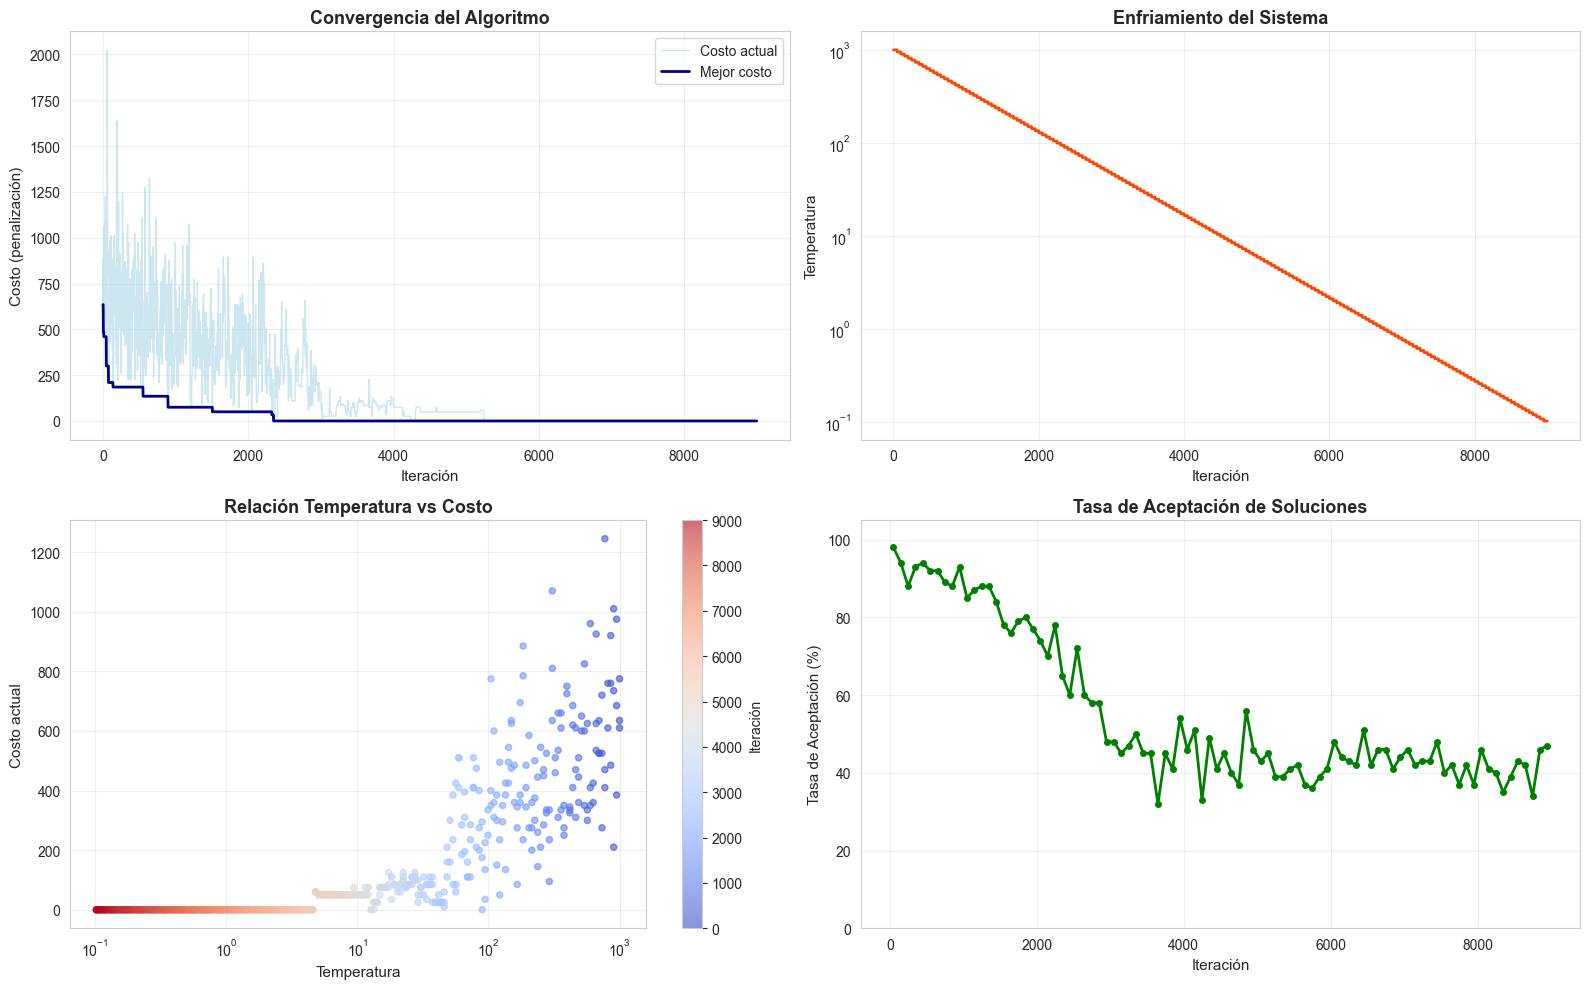


📊 Estadísticas del algoritmo:
   Costo inicial:      635
   Costo final:        0
   Mejora:             635 (100.0%)
   Soluciones aceptadas: 4964 de 9000 (55.2%)


In [5]:
# Gráfico 1: Convergencia del algoritmo y temperatura
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Subplot 1: Evolución del costo
axes[0, 0].plot(historial['costos'], alpha=0.6, linewidth=1, label='Costo actual', color='lightblue')
axes[0, 0].plot(historial['mejor_costo'], linewidth=2, label='Mejor costo', color='darkblue')
axes[0, 0].set_xlabel('Iteración', fontsize=11)
axes[0, 0].set_ylabel('Costo (penalización)', fontsize=11)
axes[0, 0].set_title('Convergencia del Algoritmo', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Evolución de la temperatura
axes[0, 1].plot(historial['temperaturas'], linewidth=2, color='orangered')
axes[0, 1].set_xlabel('Iteración', fontsize=11)
axes[0, 1].set_ylabel('Temperatura', fontsize=11)
axes[0, 1].set_title('Enfriamiento del Sistema', fontsize=13, fontweight='bold')
axes[0, 1].set_yscale('log')  # Escala logarítmica para ver mejor la curva
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Temperatura vs Costo (scatter plot)
# Tomar una muestra para no saturar el gráfico
muestra = np.arange(0, len(historial['temperaturas']), max(1, len(historial['temperaturas'])//500))
temps_muestra = [historial['temperaturas'][i] for i in muestra]
costos_muestra = [historial['costos'][i] for i in muestra]

scatter = axes[1, 0].scatter(temps_muestra, costos_muestra, 
                            c=muestra, cmap='coolwarm', alpha=0.6, s=20)
axes[1, 0].set_xlabel('Temperatura', fontsize=11)
axes[1, 0].set_ylabel('Costo actual', fontsize=11)
axes[1, 0].set_title('Relación Temperatura vs Costo', fontsize=13, fontweight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 0], label='Iteración')

# Subplot 4: Tasa de aceptación en ventanas
# Calcular tasa de aceptación en ventanas de 100 iteraciones
ventana = 100
tasas_aceptacion = []
iteraciones_ventana = []

for i in range(0, len(historial['aceptaciones']), ventana):
    ventana_actual = historial['aceptaciones'][i:i+ventana]
    if len(ventana_actual) > 0:
        tasa = sum(ventana_actual) / len(ventana_actual) * 100
        tasas_aceptacion.append(tasa)
        iteraciones_ventana.append(i + ventana//2)

axes[1, 1].plot(iteraciones_ventana, tasas_aceptacion, linewidth=2, color='green', marker='o', markersize=4)
axes[1, 1].set_xlabel('Iteración', fontsize=11)
axes[1, 1].set_ylabel('Tasa de Aceptación (%)', fontsize=11)
axes[1, 1].set_title('Tasa de Aceptación de Soluciones', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas del algoritmo:")
print(f"   Costo inicial:      {historial['costos'][0]}")
print(f"   Costo final:        {costo_optimo}")
print(f"   Mejora:             {historial['costos'][0] - costo_optimo} ({((historial['costos'][0] - costo_optimo) / historial['costos'][0] * 100):.1f}%)")
print(f"   Soluciones aceptadas: {sum(historial['aceptaciones'])} de {len(historial['aceptaciones'])} ({sum(historial['aceptaciones'])/len(historial['aceptaciones'])*100:.1f}%)")

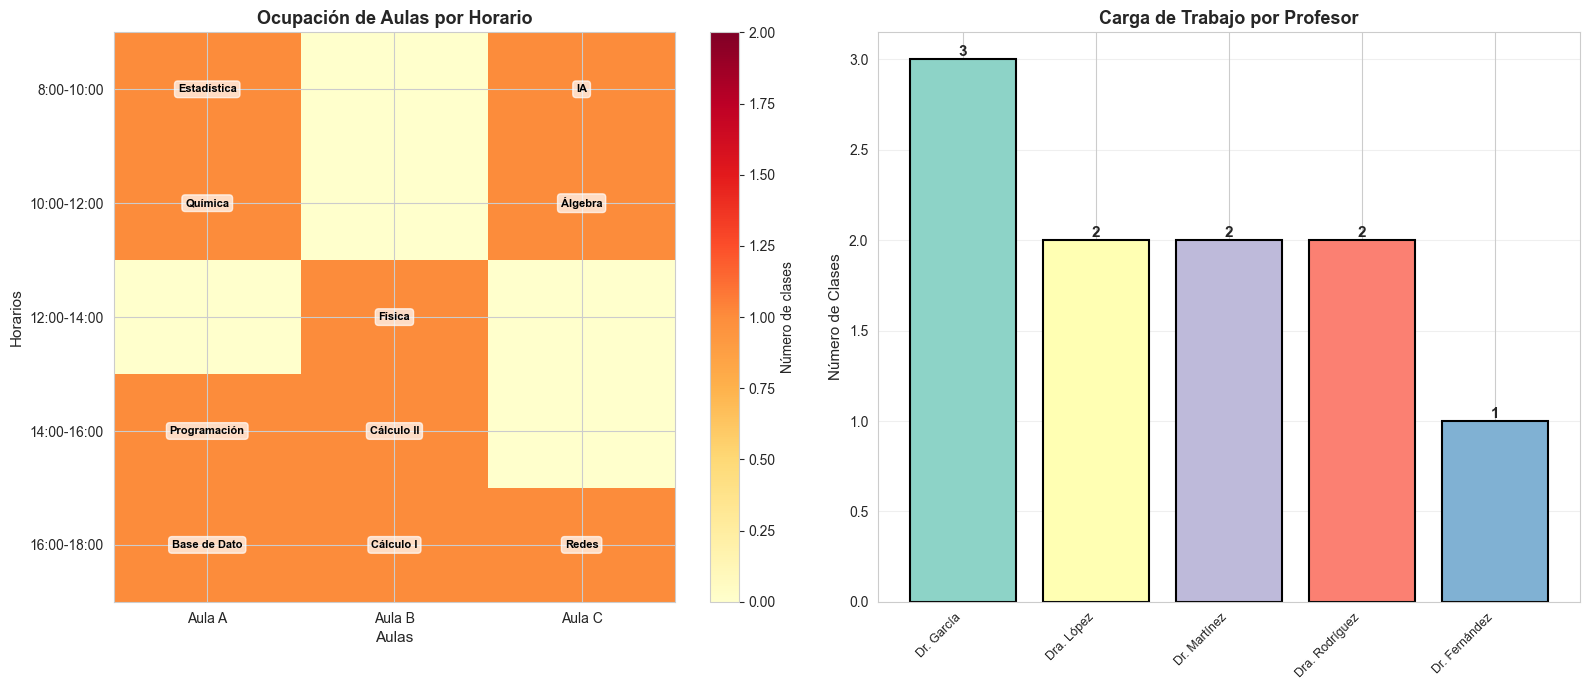


🔍 Verificación de la solución:
   Costo total: 0
   ✅ ¡Solución perfecta! Sin conflictos ni penalizaciones.


In [6]:
# Gráfico 2: Visualización del horario optimizado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Crear matriz de horarios (clases x horarios)
matriz_horario = np.zeros((len(horarios), len(aulas)))

# Mapear cada clase a su posición en la matriz
asignaciones_texto = [['' for _ in range(len(aulas))] for _ in range(len(horarios))]

for i, (h_id, a_id) in enumerate(solucion_optima):
    # Contar cuántas clases hay en esta combinación horario-aula
    matriz_horario[h_id, a_id] += 1
    # Agregar el nombre de la clase
    if asignaciones_texto[h_id][a_id]:
        asignaciones_texto[h_id][a_id] += f"\n{clases[i]['nombre'][:12]}"
    else:
        asignaciones_texto[h_id][a_id] = clases[i]['nombre'][:12]

# Subplot 1: Mapa de calor del horario
im1 = ax1.imshow(matriz_horario, cmap='YlOrRd', aspect='auto', vmin=0, vmax=2)
ax1.set_xticks(range(len(aulas)))
ax1.set_yticks(range(len(horarios)))
ax1.set_xticklabels([a['nombre'] for a in aulas], fontsize=10)
ax1.set_yticklabels(horarios, fontsize=10)
ax1.set_title('Ocupación de Aulas por Horario', fontsize=13, fontweight='bold')
ax1.set_xlabel('Aulas', fontsize=11)
ax1.set_ylabel('Horarios', fontsize=11)

# Añadir texto con los nombres de las clases
for i in range(len(horarios)):
    for j in range(len(aulas)):
        if asignaciones_texto[i][j]:
            texto = asignaciones_texto[i][j]
            ax1.text(j, i, texto, ha="center", va="center", 
                    color="black", fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.colorbar(im1, ax=ax1, label='Número de clases')

# Subplot 2: Distribución de clases por profesor
profesores = {}
for i, clase in enumerate(clases):
    prof = clase['profesor']
    if prof not in profesores:
        profesores[prof] = []
    h_id, a_id = solucion_optima[i]
    profesores[prof].append((clase['nombre'], horarios[h_id], aulas[a_id]['nombre']))

# Crear un gráfico de barras con las clases por profesor
nombres_prof = list(profesores.keys())
num_clases_prof = [len(profesores[p]) for p in nombres_prof]

colores_prof = plt.cm.Set3(range(len(nombres_prof)))
bars = ax2.bar(range(len(nombres_prof)), num_clases_prof, color=colores_prof, 
               edgecolor='black', linewidth=1.5)

ax2.set_xticks(range(len(nombres_prof)))
ax2.set_xticklabels(nombres_prof, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Número de Clases', fontsize=11)
ax2.set_title('Carga de Trabajo por Profesor', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bar, val in zip(bars, num_clases_prof):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Verificar conflictos
print("\n🔍 Verificación de la solución:")
print(f"   Costo total: {costo_optimo}")
if costo_optimo == 0:
    print("   ✅ ¡Solución perfecta! Sin conflictos ni penalizaciones.")
elif costo_optimo < 50:
    print("   ✅ Excelente solución con penalizaciones mínimas.")
elif costo_optimo < 200:
    print("   ⚠️  Solución aceptable con algunas penalizaciones.")
else:
    print("   ❌ Solución con conflictos importantes. Considerar más iteraciones.")

---

# 📚 Ejemplos Adicionales para Clase

A continuación se presentan 3 ejemplos más de Simulated Annealing con problemas del mundo real.

## Ejemplo 1: Diseño de Circuitos (Minimización de Longitud de Cables)

**Problema Real**: Colocar 8 componentes electrónicos en una placa para minimizar la longitud total de cables.

**Dificultad**: ⭐⭐ Media

**Aplicación**: Diseño de PCB (Printed Circuit Boards), optimización de layouts

In [7]:
# Definir componentes que necesitan ser conectados
componentes = ['CPU', 'RAM', 'GPU', 'Storage', 'Power', 'USB', 'Network', 'Audio']

# Definir conexiones necesarias (matriz de adyacencia: 1 = necesita conexión)
# Cada componente puede necesitar estar conectado con otros
conexiones = np.array([
    #CPU RAM GPU Sto Pow USB Net Aud
    [0,  1,  1,  1,  1,  0,  0,  0],  # CPU
    [1,  0,  0,  0,  1,  0,  0,  0],  # RAM
    [1,  0,  0,  0,  1,  0,  0,  0],  # GPU
    [1,  0,  0,  0,  1,  0,  0,  0],  # Storage
    [1,  1,  1,  1,  0,  1,  1,  1],  # Power (conecta con todos)
    [0,  0,  0,  0,  1,  0,  0,  0],  # USB
    [0,  0,  0,  0,  1,  0,  0,  0],  # Network
    [0,  0,  0,  0,  1,  0,  0,  0]   # Audio
])

# Función para calcular la longitud total de cables
def calcular_longitud_cables(posiciones, conexiones):
    """
    Calcula la longitud total de cables necesarios.
    
    Parámetros:
    - posiciones: lista de tuplas (x, y) con la posición de cada componente
    - conexiones: matriz que indica qué componentes deben conectarse
    
    Retorna:
    - longitud total de cables
    """
    longitud_total = 0
    n = len(posiciones)
    
    # Para cada par de componentes
    for i in range(n):
        for j in range(i + 1, n):
            # Si necesitan conexión
            if conexiones[i, j] == 1:
                # Calcular distancia euclidiana
                x1, y1 = posiciones[i]
                x2, y2 = posiciones[j]
                distancia = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                longitud_total += distancia
    
    return longitud_total


# Generar posiciones aleatorias iniciales (en una placa de 10x10)
def generar_posiciones_iniciales(num_componentes, ancho=10, alto=10):
    """
    Genera posiciones aleatorias para los componentes.
    """
    posiciones = []
    for _ in range(num_componentes):
        x = np.random.uniform(0, ancho)
        y = np.random.uniform(0, alto)
        posiciones.append((x, y))
    return posiciones


# Generar vecino: mover un componente a una nueva posición
def generar_vecino_circuito(posiciones, ancho=10, alto=10):
    """
    Genera una configuración vecina moviendo un componente.
    """
    vecino = posiciones.copy()
    # Seleccionar un componente al azar
    idx = np.random.randint(0, len(posiciones))
    # Mover ligeramente (dentro de un radio de 2 unidades)
    x, y = vecino[idx]
    nuevo_x = x + np.random.uniform(-2, 2)
    nuevo_y = y + np.random.uniform(-2, 2)
    # Mantener dentro de los límites
    nuevo_x = max(0, min(ancho, nuevo_x))
    nuevo_y = max(0, min(alto, nuevo_y))
    vecino[idx] = (nuevo_x, nuevo_y)
    return vecino


# Simulated Annealing para optimización de circuitos
def sa_circuito(componentes, conexiones, temp_inicial=100, temp_min=0.01, enfriamiento=0.95):
    """
    Aplica Simulated Annealing para minimizar la longitud de cables.
    """
    # Posición inicial aleatoria
    posiciones_actual = generar_posiciones_iniciales(len(componentes))
    energia_actual = calcular_longitud_cables(posiciones_actual, conexiones)
    
    # Mejor solución
    mejor_posiciones = posiciones_actual.copy()
    mejor_energia = energia_actual
    
    # Historial
    historial_energia = [energia_actual]
    historial_temp = [temp_inicial]
    
    # Temperatura
    temp = temp_inicial
    
    # Bucle principal
    while temp > temp_min:
        for _ in range(50):  # Iteraciones por temperatura
            # Generar vecino
            posiciones_vecino = generar_vecino_circuito(posiciones_actual)
            energia_vecino = calcular_longitud_cables(posiciones_vecino, conexiones)
            
            # Calcular diferencia de energía
            delta = energia_vecino - energia_actual
            
            # Decidir si aceptar
            if delta < 0 or np.random.random() < np.exp(-delta / temp):
                posiciones_actual = posiciones_vecino
                energia_actual = energia_vecino
                
                # Actualizar mejor
                if energia_actual < mejor_energia:
                    mejor_posiciones = posiciones_actual.copy()
                    mejor_energia = energia_actual
            
            # Registrar
            historial_energia.append(energia_actual)
            historial_temp.append(temp)
        
        # Enfriar
        temp *= enfriamiento
    
    return mejor_posiciones, mejor_energia, historial_energia, historial_temp


# Ejecutar optimización
print("=== OPTIMIZACIÓN DE DISEÑO DE CIRCUITO ===\n")
np.random.seed(456)
pos_inicial = generar_posiciones_iniciales(len(componentes))
longitud_inicial = calcular_longitud_cables(pos_inicial, conexiones)

pos_optima, longitud_optima, hist_energia, hist_temp = sa_circuito(componentes, conexiones)

print(f"Longitud inicial de cables: {longitud_inicial:.2f} unidades")
print(f"Longitud optimizada:        {longitud_optima:.2f} unidades")
print(f"Reducción:                  {longitud_inicial - longitud_optima:.2f} unidades ({(longitud_inicial - longitud_optima)/longitud_inicial*100:.1f}%)")

=== OPTIMIZACIÓN DE DISEÑO DE CIRCUITO ===

Longitud inicial de cables: 61.57 unidades
Longitud optimizada:        1.00 unidades
Reducción:                  60.57 unidades (98.4%)


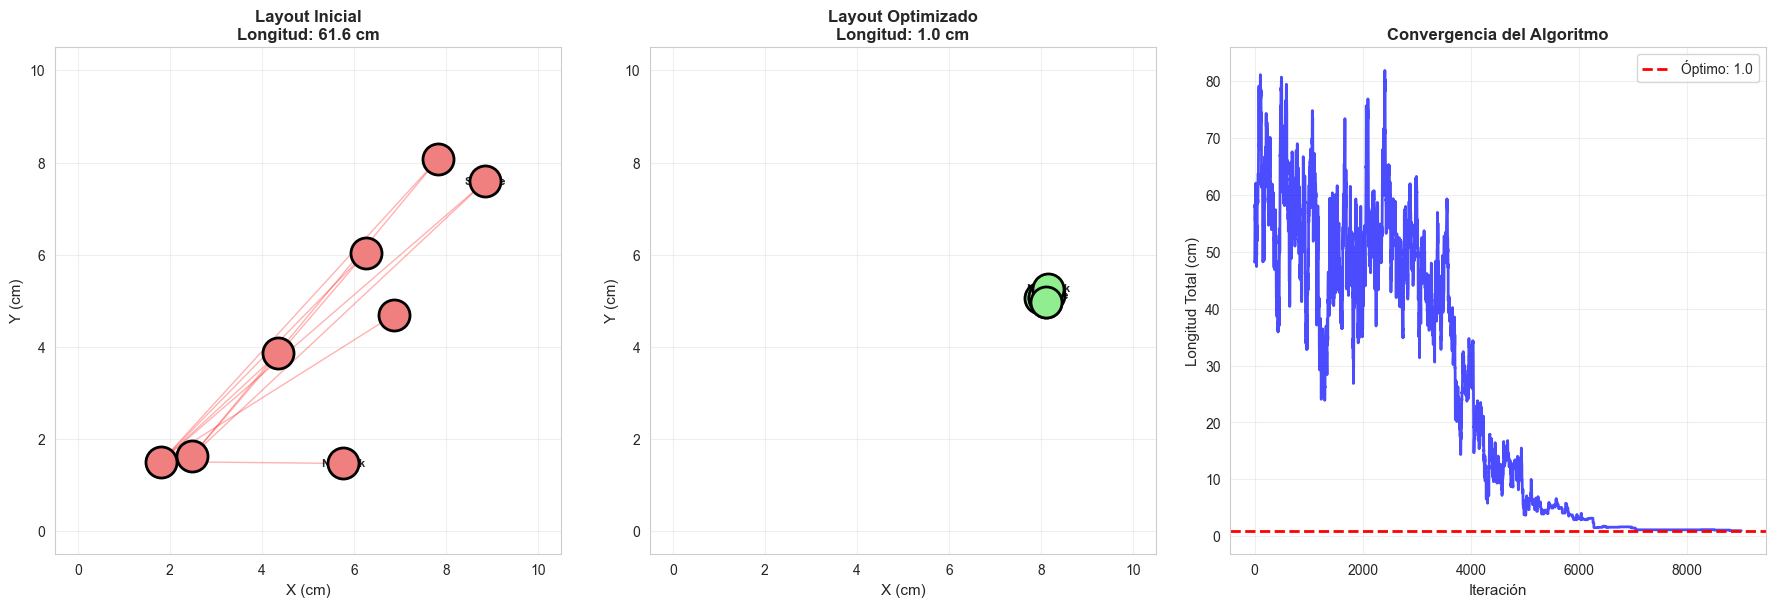


💡 Ahorro de cable: 60.57 cm


In [8]:
# Visualizar el diseño del circuito
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Configuración inicial
ax = axes[0]
for i, (x, y) in enumerate(pos_inicial):
    ax.scatter(x, y, s=500, c='lightcoral', edgecolors='black', linewidth=2, zorder=5)
    ax.text(x, y, componentes[i], ha='center', va='center', fontsize=8, fontweight='bold')

# Dibujar conexiones iniciales
for i in range(len(componentes)):
    for j in range(i + 1, len(componentes)):
        if conexiones[i, j] == 1:
            x1, y1 = pos_inicial[i]
            x2, y2 = pos_inicial[j]
            ax.plot([x1, x2], [y1, y2], 'r-', alpha=0.3, linewidth=1)

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)
ax.set_xlabel('X (cm)', fontsize=11)
ax.set_ylabel('Y (cm)', fontsize=11)
ax.set_title(f'Layout Inicial\nLongitud: {longitud_inicial:.1f} cm', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Subplot 2: Configuración optimizada
ax = axes[1]
for i, (x, y) in enumerate(pos_optima):
    ax.scatter(x, y, s=500, c='lightgreen', edgecolors='black', linewidth=2, zorder=5)
    ax.text(x, y, componentes[i], ha='center', va='center', fontsize=8, fontweight='bold')

# Dibujar conexiones optimizadas
for i in range(len(componentes)):
    for j in range(i + 1, len(componentes)):
        if conexiones[i, j] == 1:
            x1, y1 = pos_optima[i]
            x2, y2 = pos_optima[j]
            ax.plot([x1, x2], [y1, y2], 'g-', alpha=0.5, linewidth=2)

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)
ax.set_xlabel('X (cm)', fontsize=11)
ax.set_ylabel('Y (cm)', fontsize=11)
ax.set_title(f'Layout Optimizado\nLongitud: {longitud_optima:.1f} cm', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Subplot 3: Convergencia
ax = axes[2]
ax.plot(hist_energia, linewidth=2, color='blue', alpha=0.7)
ax.axhline(y=longitud_optima, color='red', linestyle='--', linewidth=2, label=f'Óptimo: {longitud_optima:.1f}')
ax.set_xlabel('Iteración', fontsize=11)
ax.set_ylabel('Longitud Total (cm)', fontsize=11)
ax.set_title('Convergencia del Algoritmo', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Ahorro de cable: {longitud_inicial - longitud_optima:.2f} cm")

## Ejemplo 2: Optimización de Rutas de Entrega (Problema del Cartero)

**Problema Real**: Un cartero debe entregar paquetes en 12 direcciones. ¿Cuál es la ruta más corta que visita todas las direcciones y regresa al punto de partida?

**Dificultad**: ⭐⭐⭐ Media-Alta

**Aplicación**: Logística, delivery, rutas de transporte

In [9]:
# Generar direcciones aleatorias en una ciudad (coordenadas)
np.random.seed(789)
num_entregas = 12

# Generar coordenadas de las direcciones (incluyendo la oficina postal como punto 0)
direcciones = [(5, 5)]  # Oficina postal en el centro
for _ in range(num_entregas - 1):
    x = np.random.uniform(0, 10)
    y = np.random.uniform(0, 10)
    direcciones.append((x, y))

# Función para calcular distancia total de una ruta
def calcular_distancia_ruta(ruta, direcciones):
    """
    Calcula la distancia total de una ruta.
    
    Parámetros:
    - ruta: lista con el orden de visita de las direcciones
    - direcciones: lista de coordenadas (x, y)
    
    Retorna:
    - distancia total
    """
    distancia = 0
    # Sumar distancias entre puntos consecutivos
    for i in range(len(ruta) - 1):
        x1, y1 = direcciones[ruta[i]]
        x2, y2 = direcciones[ruta[i + 1]]
        distancia += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Añadir regreso a la oficina postal
    x1, y1 = direcciones[ruta[-1]]
    x2, y2 = direcciones[ruta[0]]
    distancia += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distancia


# Función para generar vecino: intercambiar dos direcciones en la ruta (2-opt)
def generar_vecino_ruta(ruta):
    """
    Genera una ruta vecina intercambiando dos posiciones.
    """
    vecino = ruta.copy()
    # Seleccionar dos posiciones aleatorias (excepto la primera que es la oficina)
    i, j = sorted(np.random.choice(range(1, len(ruta)), 2, replace=False))
    # Invertir el segmento entre i y j
    vecino[i:j+1] = reversed(vecino[i:j+1])
    return vecino


# Simulated Annealing para TSP
def sa_tsp(direcciones, temp_inicial=100, temp_min=0.01, enfriamiento=0.97):
    """
    Optimiza la ruta de entrega usando Simulated Annealing.
    """
    # Ruta inicial: visitar en orden secuencial
    ruta_actual = list(range(len(direcciones)))
    dist_actual = calcular_distancia_ruta(ruta_actual, direcciones)
    
    # Mejor ruta
    mejor_ruta = ruta_actual.copy()
    mejor_dist = dist_actual
    
    # Historial
    historial_dist = [dist_actual]
    historial_temp = [temp_inicial]
    mejoras = []  # Para marcar cuándo se encuentra una mejora
    
    temp = temp_inicial
    iteracion = 0
    
    # Bucle principal
    while temp > temp_min:
        for _ in range(100):  # Iteraciones por temperatura
            # Generar vecino
            ruta_vecina = generar_vecino_ruta(ruta_actual)
            dist_vecina = calcular_distancia_ruta(ruta_vecina, direcciones)
            
            # Calcular delta
            delta = dist_vecina - dist_actual
            
            # Decidir si aceptar
            if delta < 0 or np.random.random() < np.exp(-delta / temp):
                ruta_actual = ruta_vecina
                dist_actual = dist_vecina
                
                # Actualizar mejor
                if dist_actual < mejor_dist:
                    mejor_ruta = ruta_actual.copy()
                    mejor_dist = dist_actual
                    mejoras.append(iteracion)
            
            # Guardar historial
            historial_dist.append(dist_actual)
            historial_temp.append(temp)
            iteracion += 1
        
        # Enfriar
        temp *= enfriamiento
    
    return mejor_ruta, mejor_dist, historial_dist, historial_temp, mejoras


# Ejecutar optimización
print("=== OPTIMIZACIÓN DE RUTA DE ENTREGAS ===\n")
ruta_inicial = list(range(len(direcciones)))
dist_inicial = calcular_distancia_ruta(ruta_inicial, direcciones)

ruta_optima, dist_optima, hist_dist, hist_temp, mejoras = sa_tsp(direcciones)

print(f"Distancia inicial (ruta secuencial): {dist_inicial:.2f} km")
print(f"Distancia optimizada:                {dist_optima:.2f} km")
print(f"Ahorro:                              {dist_inicial - dist_optima:.2f} km ({(dist_inicial - dist_optima)/dist_inicial*100:.1f}%)")
print(f"Mejoras encontradas:                 {len(mejoras)} veces")

print(f"\n📍 Ruta optimizada:")
print(f"   Oficina Postal", end='')
for i in ruta_optima[1:]:
    print(f" → Dirección {i}", end='')
print(" → Oficina Postal")

=== OPTIMIZACIÓN DE RUTA DE ENTREGAS ===

Distancia inicial (ruta secuencial): 57.00 km
Distancia optimizada:                29.79 km
Ahorro:                              27.21 km (47.7%)
Mejoras encontradas:                 19 veces

📍 Ruta optimizada:
   Oficina Postal → Dirección 10 → Dirección 11 → Dirección 5 → Dirección 6 → Dirección 4 → Dirección 9 → Dirección 1 → Dirección 7 → Dirección 3 → Dirección 2 → Dirección 8 → Oficina Postal


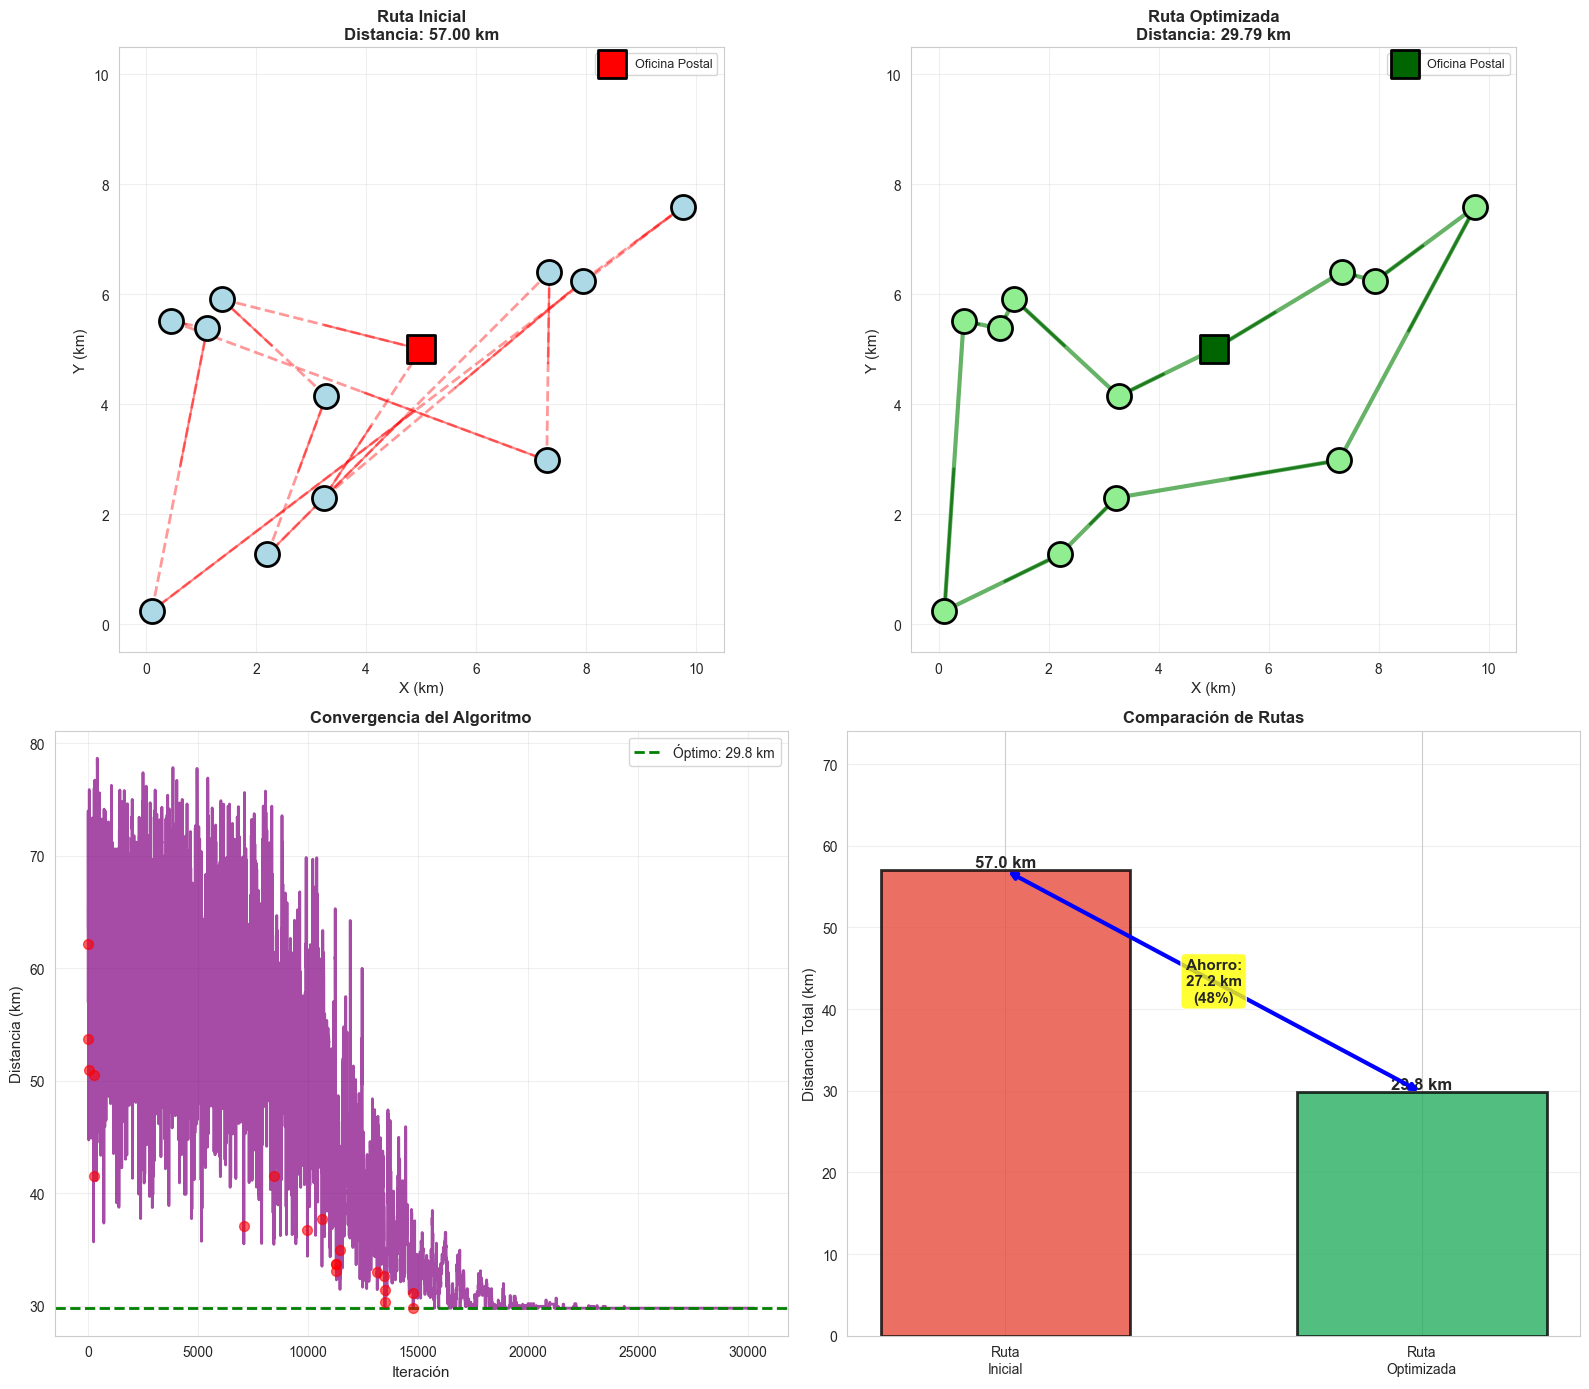


🚗 Tiempo estimado de ahorro: 81.6 minutos (a 20 km/h)


In [10]:
# Visualizar las rutas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Subplot 1: Ruta inicial
ax = axes[0, 0]
# Dibujar direcciones
for i, (x, y) in enumerate(direcciones):
    if i == 0:
        ax.scatter(x, y, s=400, c='red', marker='s', edgecolors='black', linewidth=2, zorder=5, label='Oficina Postal')
        ax.text(x, y, 'O', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    else:
        ax.scatter(x, y, s=300, c='lightblue', edgecolors='black', linewidth=2, zorder=5)
        ax.text(x, y, str(i), ha='center', va='center', fontsize=10, fontweight='bold')

# Dibujar ruta inicial
for i in range(len(ruta_inicial)):
    x1, y1 = direcciones[ruta_inicial[i]]
    x2, y2 = direcciones[ruta_inicial[(i + 1) % len(ruta_inicial)]]
    ax.plot([x1, x2], [y1, y2], 'r--', alpha=0.4, linewidth=2)
    # Añadir flecha
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    ax.annotate('', xy=(x2, y2), xytext=(mid_x, mid_y),
               arrowprops=dict(arrowstyle='->', color='red', lw=1.5, alpha=0.5))

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)
ax.set_xlabel('X (km)', fontsize=11)
ax.set_ylabel('Y (km)', fontsize=11)
ax.set_title(f'Ruta Inicial\nDistancia: {dist_inicial:.2f} km', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Subplot 2: Ruta optimizada
ax = axes[0, 1]
# Dibujar direcciones
for i, (x, y) in enumerate(direcciones):
    if i == 0:
        ax.scatter(x, y, s=400, c='darkgreen', marker='s', edgecolors='black', linewidth=2, zorder=5, label='Oficina Postal')
        ax.text(x, y, 'O', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    else:
        ax.scatter(x, y, s=300, c='lightgreen', edgecolors='black', linewidth=2, zorder=5)
        ax.text(x, y, str(i), ha='center', va='center', fontsize=10, fontweight='bold')

# Dibujar ruta optimizada
for i in range(len(ruta_optima)):
    x1, y1 = direcciones[ruta_optima[i]]
    x2, y2 = direcciones[ruta_optima[(i + 1) % len(ruta_optima)]]
    ax.plot([x1, x2], [y1, y2], 'g-', alpha=0.6, linewidth=3)
    # Añadir flecha
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    ax.annotate('', xy=(x2, y2), xytext=(mid_x, mid_y),
               arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2, alpha=0.7))

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)
ax.set_xlabel('X (km)', fontsize=11)
ax.set_ylabel('Y (km)', fontsize=11)
ax.set_title(f'Ruta Optimizada\nDistancia: {dist_optima:.2f} km', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Subplot 3: Convergencia
ax = axes[1, 0]
ax.plot(hist_dist, linewidth=2, color='purple', alpha=0.7)
ax.axhline(y=dist_optima, color='green', linestyle='--', linewidth=2, label=f'Óptimo: {dist_optima:.1f} km')
# Marcar las mejoras
for mejora_iter in mejoras[:20]:  # Mostrar solo las primeras 20 mejoras
    if mejora_iter < len(hist_dist):
        ax.scatter(mejora_iter, hist_dist[mejora_iter], c='red', s=50, zorder=5, alpha=0.6)
ax.set_xlabel('Iteración', fontsize=11)
ax.set_ylabel('Distancia (km)', fontsize=11)
ax.set_title('Convergencia del Algoritmo', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Subplot 4: Comparación de distancias
ax = axes[1, 1]
categorias = ['Ruta\nInicial', 'Ruta\nOptimizada']
distancias = [dist_inicial, dist_optima]
colores = ['#E74C3C', '#27AE60']
bars = ax.bar(categorias, distancias, color=colores, edgecolor='black', linewidth=2, alpha=0.8, width=0.6)

# Añadir valores
for bar, dist in zip(bars, distancias):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{dist:.1f} km', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Añadir flecha de ahorro
ax.annotate('', xy=(1, dist_optima), xytext=(0, dist_inicial),
           arrowprops=dict(arrowstyle='<->', color='blue', lw=3))
ahorro = dist_inicial - dist_optima
ax.text(0.5, (dist_inicial + dist_optima)/2, f'Ahorro:\n{ahorro:.1f} km\n({ahorro/dist_inicial*100:.0f}%)',
       ha='center', va='center', fontsize=11, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax.set_ylabel('Distancia Total (km)', fontsize=11)
ax.set_title('Comparación de Rutas', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(distancias) * 1.3)

plt.tight_layout()
plt.show()

print(f"\n🚗 Tiempo estimado de ahorro: {(dist_inicial - dist_optima) * 3:.1f} minutos (a 20 km/h)")

## Ejemplo 3: Asignación de Turnos de Enfermeras

**Problema Real**: Asignar turnos de trabajo a 6 enfermeras durante una semana, respetando restricciones laborales y preferencias.

**Dificultad**: ⭐⭐ Media

**Aplicación**: Gestión de recursos humanos, hospitales, centros de atención 24/7

In [11]:
# Definir enfermeras y turnos
enfermeras = ['Ana', 'Beatriz', 'Carmen', 'Diana', 'Elena', 'Fernanda']
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
turnos = ['Mañana', 'Tarde', 'Noche']  # 3 turnos por día

# Necesidades de personal por turno (número mínimo de enfermeras)
necesidades = {
    'Mañana': 2,   # 2 enfermeras en turno de mañana
    'Tarde': 2,    # 2 enfermeras en turno de tarde
    'Noche': 1     # 1 enfermera en turno de noche
}

# Función para calcular el costo de un horario
def calcular_costo_turnos(horario, enfermeras, dias, turnos, necesidades):
    """
    Calcula el costo de una asignación de turnos.
    
    Parámetros:
    - horario: matriz [enfermera][día] con el turno asignado (0=Mañana, 1=Tarde, 2=Noche, 3=Descanso)
    - enfermeras: lista de nombres
    - dias: lista de días
    - turnos: lista de turnos
    - necesidades: dict con personal mínimo por turno
    
    Retorna:
    - costo total (menor es mejor)
    """
    costo = 0
    num_enfermeras = len(enfermeras)
    num_dias = len(dias)
    
    # Penalización 1: Necesidades de personal no cubiertas
    for dia_idx in range(num_dias):
        # Contar enfermeras por turno en este día
        turnos_dia = [0, 0, 0]  # [Mañana, Tarde, Noche]
        for enf_idx in range(num_enfermeras):
            turno = horario[enf_idx][dia_idx]
            if turno < 3:  # No es descanso
                turnos_dia[turno] += 1
        
        # Verificar si se cumplen las necesidades
        for turno_idx, turno_nombre in enumerate(turnos):
            deficit = necesidades[turno_nombre] - turnos_dia[turno_idx]
            if deficit > 0:
                costo += deficit * 100  # Penalización fuerte por falta de personal
    
    # Penalización 2: Enfermera trabaja más de 5 días seguidos
    for enf_idx in range(num_enfermeras):
        dias_consecutivos = 0
        for dia_idx in range(num_dias):
            if horario[enf_idx][dia_idx] < 3:  # Trabaja (no descanso)
                dias_consecutivos += 1
                if dias_consecutivos > 5:
                    costo += 50  # Penalización por sobrecargar a una enfermera
            else:
                dias_consecutivos = 0
    
    # Penalización 3: Cambios de turno drásticos (noche → mañana al día siguiente)
    for enf_idx in range(num_enfermeras):
        for dia_idx in range(num_dias - 1):
            if horario[enf_idx][dia_idx] == 2 and horario[enf_idx][dia_idx + 1] == 0:
                costo += 30  # Penalización por cambio drástico (noche → mañana)
    
    # Penalización 4: Distribución desigual de trabajo
    # Contar días trabajados por cada enfermera
    dias_trabajados = []
    for enf_idx in range(num_enfermeras):
        dias = sum(1 for dia in horario[enf_idx] if dia < 3)
        dias_trabajados.append(dias)
    
    # Calcular desviación estándar
    promedio = np.mean(dias_trabajados)
    desviacion = np.std(dias_trabajados)
    costo += desviacion * 10  # Penalizar distribución desigual
    
    return costo


# Generar horario inicial aleatorio
def generar_horario_inicial(num_enfermeras, num_dias):
    """
    Genera un horario aleatorio.
    0=Mañana, 1=Tarde, 2=Noche, 3=Descanso
    """
    horario = []
    for _ in range(num_enfermeras):
        semana = [np.random.randint(0, 4) for _ in range(num_dias)]
        horario.append(semana)
    return horario


# Generar vecino: cambiar el turno de una enfermera en un día
def generar_vecino_turnos(horario):
    """
    Genera un horario vecino cambiando un turno.
    """
    vecino = [semana.copy() for semana in horario]
    # Seleccionar enfermera y día al azar
    enf_idx = np.random.randint(0, len(vecino))
    dia_idx = np.random.randint(0, len(vecino[0]))
    # Cambiar a un turno diferente
    vecino[enf_idx][dia_idx] = np.random.randint(0, 4)
    return vecino


# Simulated Annealing para turnos
def sa_turnos(enfermeras, dias, turnos, necesidades, temp_inicial=50, temp_min=0.01, enfriamiento=0.95):
    """
    Optimiza la asignación de turnos.
    """
    # Horario inicial
    horario_actual = generar_horario_inicial(len(enfermeras), len(dias))
    costo_actual = calcular_costo_turnos(horario_actual, enfermeras, dias, turnos, necesidades)
    
    # Mejor horario
    mejor_horario = [semana.copy() for semana in horario_actual]
    mejor_costo = costo_actual
    
    # Historial
    historial_costo = [costo_actual]
    
    temp = temp_inicial
    
    # Bucle principal
    while temp > temp_min:
        for _ in range(100):
            # Generar vecino
            horario_vecino = generar_vecino_turnos(horario_actual)
            costo_vecino = calcular_costo_turnos(horario_vecino, enfermeras, dias, turnos, necesidades)
            
            # Calcular delta
            delta = costo_vecino - costo_actual
            
            # Decidir si aceptar
            if delta < 0 or np.random.random() < np.exp(-delta / temp):
                horario_actual = horario_vecino
                costo_actual = costo_vecino
                
                if costo_actual < mejor_costo:
                    mejor_horario = [semana.copy() for semana in horario_actual]
                    mejor_costo = costo_actual
            
            historial_costo.append(costo_actual)
        
        temp *= enfriamiento
    
    return mejor_horario, mejor_costo, historial_costo


# Ejecutar optimización
print("=== OPTIMIZACIÓN DE TURNOS DE ENFERMERAS ===\n")
np.random.seed(321)
horario_inicial = generar_horario_inicial(len(enfermeras), len(dias))
costo_inicial = calcular_costo_turnos(horario_inicial, enfermeras, dias, turnos, necesidades)

horario_optimo, costo_optimo, hist_costo = sa_turnos(enfermeras, dias, turnos, necesidades)

print(f"Costo inicial:    {costo_inicial}")
print(f"Costo optimizado: {costo_optimo}")
print(f"Mejora:           {costo_inicial - costo_optimo} puntos")

# Nombres de turnos
turnos_nombres = ['Mañana', 'Tarde', 'Noche', 'Descanso']

print(f"\n📅 Horario Optimizado:\n")
print(f"{'Enfermera':12}", end='')
for dia in dias:
    print(f" {dia[:3]:10}", end='')
print()
print("-" * 85)

for i, nombre in enumerate(enfermeras):
    print(f"{nombre:12}", end='')
    for j in range(len(dias)):
        turno_idx = horario_optimo[i][j]
        turno_str = turnos_nombres[turno_idx][:3]
        print(f" {turno_str:10}", end='')
    print()

=== OPTIMIZACIÓN DE TURNOS DE ENFERMERAS ===

Costo inicial:    1347.4535599249994
Costo optimizado: 3.7267799624996503
Mejora:           1343.7267799624997 puntos

📅 Horario Optimizado:

Enfermera    Lun        Mar        Mié        Jue        Vie        Sáb        Dom       
-------------------------------------------------------------------------------------
Ana          Mañ        Mañ        Mañ        Des        Mañ        Mañ        Tar       
Beatriz      Des        Tar        Tar        Tar        Tar        Noc        Des       
Carmen       Tar        Noc        Des        Mañ        Mañ        Tar        Noc       
Diana        Noc        Tar        Noc        Tar        Des        Mañ        Mañ       
Elena        Tar        Mañ        Mañ        Noc        Tar        Des        Mañ       
Fernanda     Mañ        Des        Tar        Mañ        Noc        Tar        Tar       


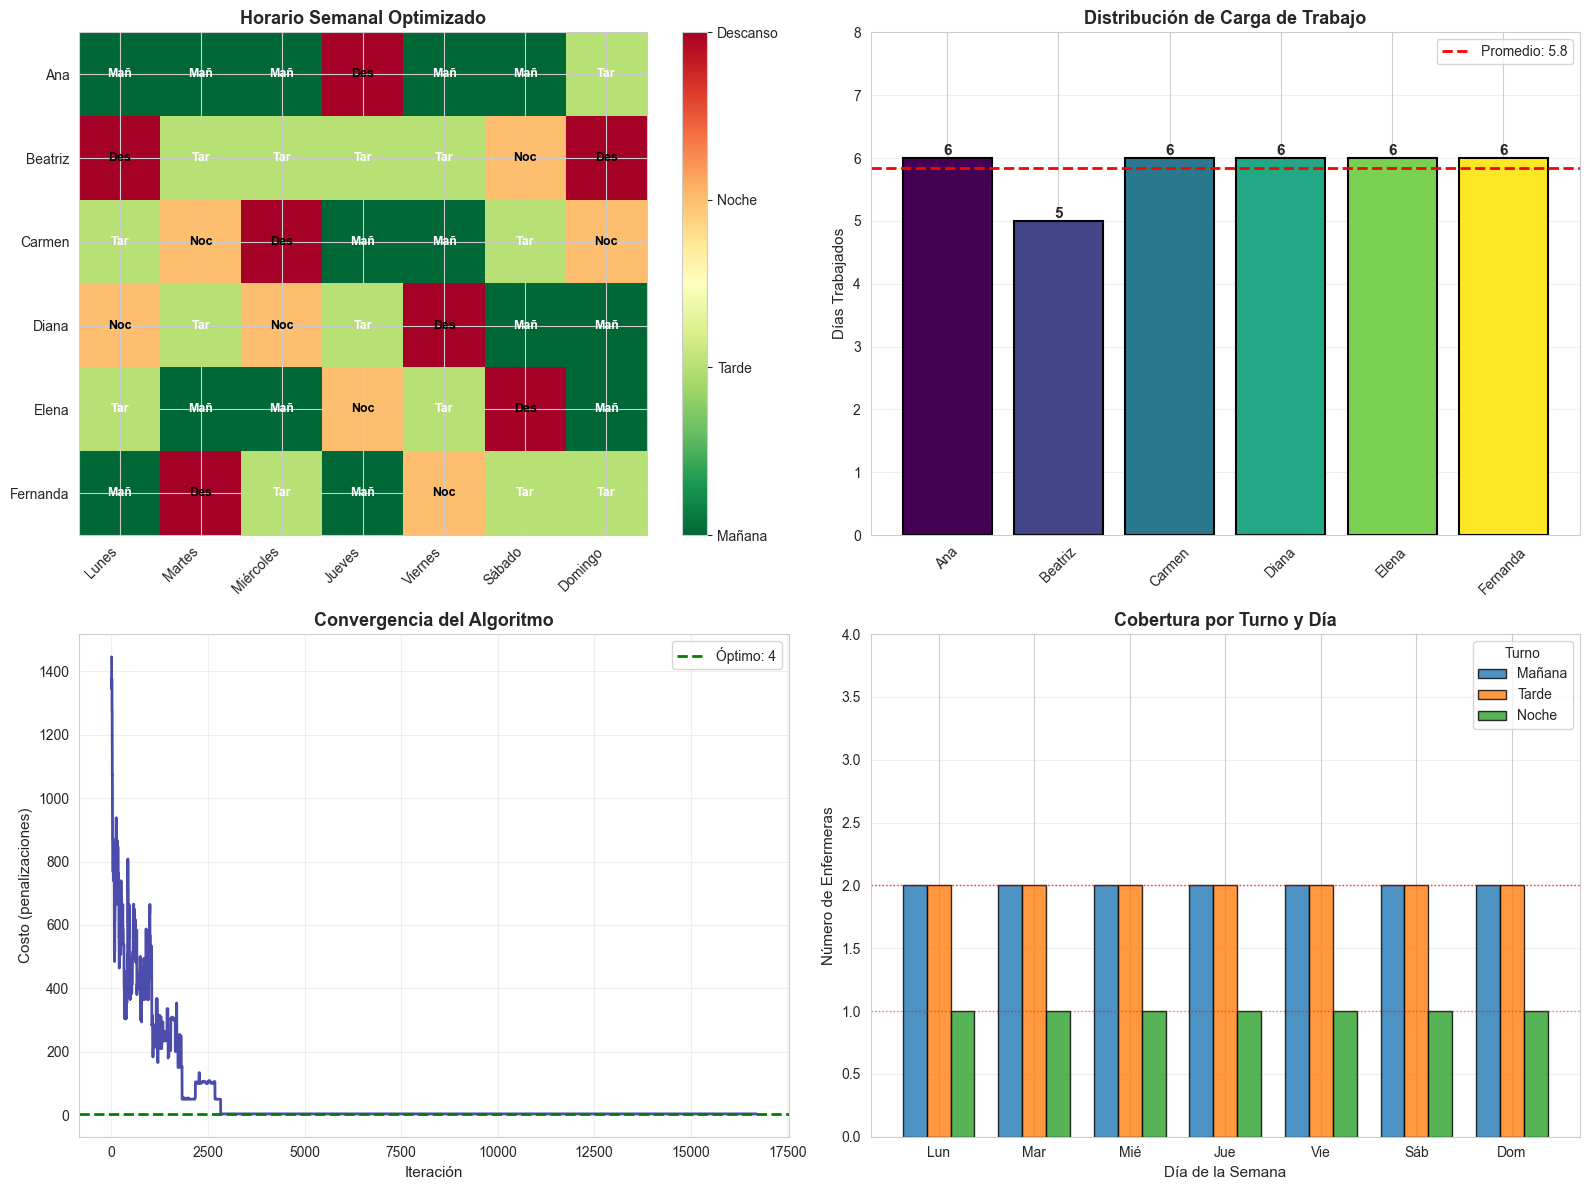


✅ Verificación de restricciones:
   Costo final: 3.7267799624996503
   ✅ Horario muy bueno con violaciones mínimas


In [22]:
# Visualizar el horario optimizado
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Mapa de calor del horario
ax = axes[0, 0]
horario_matriz = np.array(horario_optimo)
im = ax.imshow(horario_matriz, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=3)

dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
ax.set_xticks(range(len(dias_semana)))
ax.set_yticks(range(len(enfermeras)))
ax.set_xticklabels(dias_semana, fontsize=10, rotation=45, ha='right')
ax.set_yticklabels(enfermeras, fontsize=10)
ax.set_title('Horario Semanal Optimizado', fontsize=13, fontweight='bold')

# Añadir texto en cada celda
for i in range(len(enfermeras)):
    for j in range(len(dias_semana)):
        texto = turnos_nombres[horario_matriz[i, j]][:3]
        color = 'white' if horario_matriz[i, j] < 2 else 'black'
        ax.text(j, i, texto, ha="center", va="center", 
               color=color, fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Mañana', 'Tarde', 'Noche', 'Descanso'])

# Subplot 2: Días trabajados por enfermera
ax = axes[0, 1]
dias_trabajados = []
for i in range(len(enfermeras)):
    dias_trab = sum(1 for turno in horario_optimo[i] if turno < 3)
    dias_trabajados.append(dias_trab)

colores = plt.cm.viridis(np.linspace(0, 1, len(enfermeras)))
bars = ax.bar(enfermeras, dias_trabajados, color=colores, edgecolor='black', linewidth=1.5)

# Añadir valores
for bar, val in zip(bars, dias_trabajados):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(val)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Línea promedio
promedio = np.mean(dias_trabajados)
ax.axhline(y=promedio, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio:.1f}')

ax.set_ylabel('Días Trabajados', fontsize=11)
ax.set_title('Distribución de Carga de Trabajo', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 8)

# Subplot 3: Convergencia del costo
ax = axes[1, 0]
ax.plot(hist_costo, linewidth=2, color='darkblue', alpha=0.7)
ax.axhline(y=costo_optimo, color='green', linestyle='--', linewidth=2, label=f'Óptimo: {costo_optimo:.0f}')
ax.set_xlabel('Iteración', fontsize=11)
ax.set_ylabel('Costo (penalizaciones)', fontsize=11)
ax.set_title('Convergencia del Algoritmo', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Subplot 4: Cobertura por turno y día
ax = axes[1, 1]
cobertura = {turno: [] for turno in turnos}
num_dias = 7  # Número de días en la semana

for dia_idx in range(num_dias):
    for turno_idx, turno_nombre in enumerate(turnos):
        # Contar enfermeras en este turno este día
        count = sum(1 for enf_idx in range(len(enfermeras)) 
                   if horario_optimo[enf_idx][dia_idx] == turno_idx)
        cobertura[turno_nombre].append(count)

x = np.arange(num_dias)
width = 0.25

# Crear barras agrupadas
for i, (turno, counts) in enumerate(cobertura.items()):
    offset = (i - 1) * width
    bars = ax.bar(x + offset, counts, width, label=turno, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Añadir línea de necesidad
    ax.axhline(y=necesidades[turno], color='red', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Día de la Semana', fontsize=11)
ax.set_ylabel('Número de Enfermeras', fontsize=11)
ax.set_title('Cobertura por Turno y Día', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([d[:3] for d in dias_semana])
ax.legend(title='Turno', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 4)

plt.tight_layout()
plt.show()

# Verificar restricciones
print(f"\n✅ Verificación de restricciones:")
print(f"   Costo final: {costo_optimo}")
if costo_optimo == 0:
    print("   ✅ Todas las restricciones cumplidas perfectamente!")
elif costo_optimo < 100:
    print("   ✅ Horario muy bueno con violaciones mínimas")
else:
    print(f"   ⚠️  Horario aceptable pero con {int(costo_optimo//100)} violaciones importantes")

---

## 📊 Comparación: Simulated Annealing vs Hill Climbing

Veamos cómo se comporta Simulated Annealing comparado con Hill Climbing en un problema multimodal.

In [17]:
# Función multimodal con varios óptimos locales
def funcion_multimodal(x):
    """
    Función con múltiples óptimos locales.
    f(x) = -x*sin(x) + 5
    """
    return -x * np.sin(x) + 5


# Hill Climbing simple
def hill_climbing_comparacion(func, x_inicial, max_iter=200):
    """Hill Climbing sin escape de óptimos locales."""
    x_actual = x_inicial
    f_actual = func(x_actual)
    
    historial = [f_actual]
    paso = 0.5
    
    for _ in range(max_iter):
        # Probar vecinos
        x_izq = x_actual - paso
        x_der = x_actual + paso
        
        f_izq = func(x_izq)
        f_der = func(x_der)
        
        # Moverse al mejor vecino solo si mejora
        if f_izq > f_actual:
            x_actual = x_izq
            f_actual = f_izq
        elif f_der > f_actual:
            x_actual = x_der
            f_actual = f_der
        else:
            paso *= 0.5  # Reducir paso
            if paso < 0.01:
                break
        
        historial.append(f_actual)
    
    return x_actual, f_actual, historial


# Simulated Annealing para la misma función
def sa_comparacion(func, x_inicial, temp_inicial=10, temp_min=0.01, enfriamiento=0.95):
    """Simulated Annealing que puede escapar de óptimos locales."""
    x_actual = x_inicial
    f_actual = func(x_actual)
    
    mejor_x = x_actual
    mejor_f = f_actual
    
    historial = [f_actual]
    temp = temp_inicial
    
    while temp > temp_min:
        for _ in range(50):
            # Generar vecino
            x_vecino = x_actual + np.random.uniform(-1, 1)
            f_vecino = func(x_vecino)
            
            # Calcular delta (queremos maximizar)
            delta = f_vecino - f_actual
            
            # Decidir si aceptar
            if delta > 0 or np.random.random() < np.exp(delta / temp):
                x_actual = x_vecino
                f_actual = f_vecino
                
                if f_actual > mejor_f:
                    mejor_x = x_actual
                    mejor_f = f_actual
            
            historial.append(f_actual)
        
        temp *= enfriamiento
    
    return mejor_x, mejor_f, historial


# Ejecutar ambos algoritmos desde el mismo punto inicial
print("=== COMPARACIÓN: SA vs HILL CLIMBING ===\n")
x_inicio = 2.0  # Punto inicial (cerca de un óptimo local)

# Hill Climbing
x_hc, f_hc, hist_hc = hill_climbing_comparacion(funcion_multimodal, x_inicio)

# Simulated Annealing
np.random.seed(42)
x_sa, f_sa, hist_sa = sa_comparacion(funcion_multimodal, x_inicio)

print(f"Punto inicial: x={x_inicio}, f(x)={funcion_multimodal(x_inicio):.3f}")
print(f"\n📈 Hill Climbing:")
print(f"   Mejor x = {x_hc:.3f}")
print(f"   Mejor f(x) = {f_hc:.3f}")
print(f"\n🔥 Simulated Annealing:")
print(f"   Mejor x = {x_sa:.3f}")
print(f"   Mejor f(x) = {f_sa:.3f}")
print(f"\n✓ Mejora de SA sobre HC: {f_sa - f_hc:.3f} ({(f_sa - f_hc)/f_hc*100:.1f}%)")

=== COMPARACIÓN: SA vs HILL CLIMBING ===

Punto inicial: x=2.0, f(x)=3.181

📈 Hill Climbing:
   Mejor x = 0.000
   Mejor f(x) = 5.000

🔥 Simulated Annealing:
   Mejor x = -17.336
   Mejor f(x) = 22.308

✓ Mejora de SA sobre HC: 17.308 (346.2%)


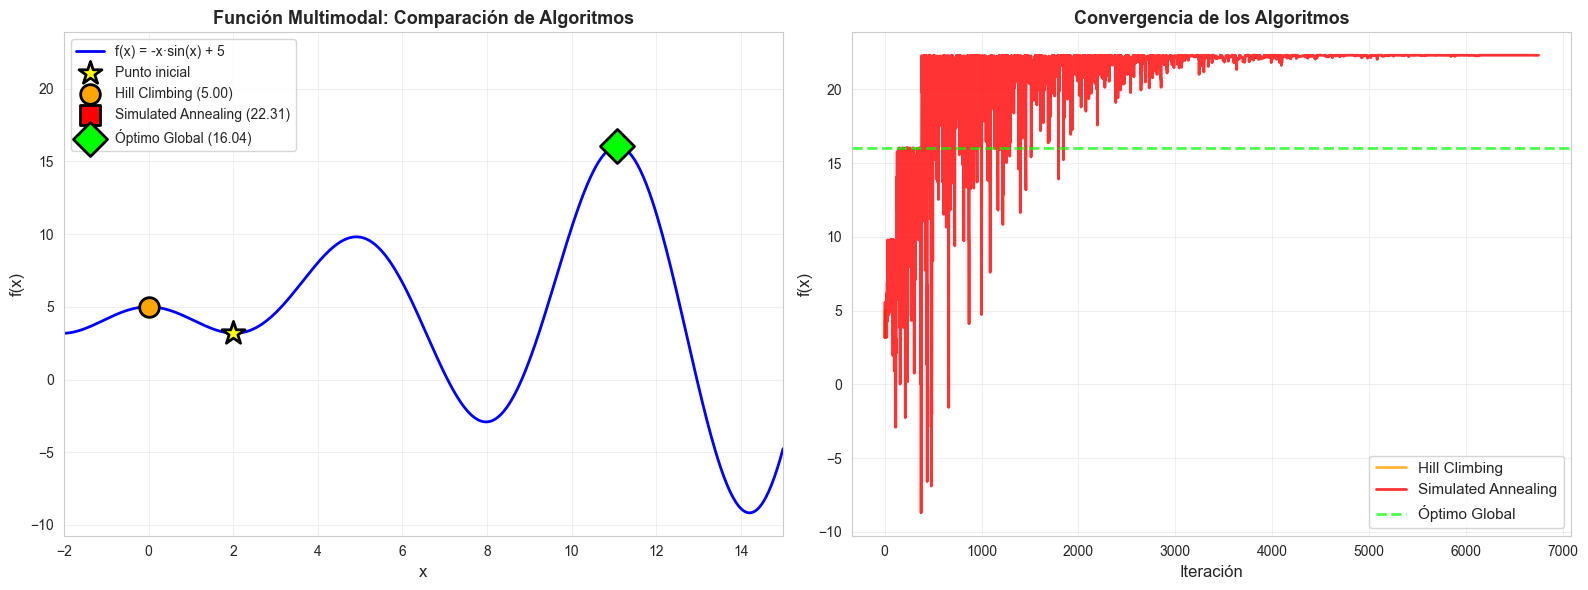


💡 Observaciones:
   • Hill Climbing se queda atrapado en un óptimo local
   • Simulated Annealing explora más y encuentra un mejor óptimo
   • SA acepta temporalmente soluciones peores para escapar de óptimos locales


In [18]:
# Visualizar la comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Función y soluciones encontradas
ax = axes[0]
x_range = np.linspace(-2, 15, 500)
y_range = [funcion_multimodal(x) for x in x_range]

# Dibujar la función
ax.plot(x_range, y_range, 'b-', linewidth=2, label='f(x) = -x·sin(x) + 5')

# Marcar punto inicial
ax.scatter(x_inicio, funcion_multimodal(x_inicio), s=300, c='yellow', marker='*', 
          edgecolors='black', linewidth=2, zorder=5, label='Punto inicial')

# Marcar solución de Hill Climbing
ax.scatter(x_hc, f_hc, s=200, c='orange', marker='o', 
          edgecolors='black', linewidth=2, zorder=5, label=f'Hill Climbing ({f_hc:.2f})')

# Marcar solución de Simulated Annealing
ax.scatter(x_sa, f_sa, s=200, c='red', marker='s', 
          edgecolors='black', linewidth=2, zorder=5, label=f'Simulated Annealing ({f_sa:.2f})')

# Encontrar y marcar el óptimo global real
x_optimo_global = x_range[np.argmax(y_range)]
f_optimo_global = max(y_range)
ax.scatter(x_optimo_global, f_optimo_global, s=300, c='lime', marker='D', 
          edgecolors='black', linewidth=2, zorder=5, label=f'Óptimo Global ({f_optimo_global:.2f})')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('Función Multimodal: Comparación de Algoritmos', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-2, 15)

# Subplot 2: Convergencia de ambos algoritmos
ax = axes[1]
ax.plot(hist_hc, linewidth=2, color='orange', alpha=0.8, label='Hill Climbing')
ax.plot(hist_sa, linewidth=2, color='red', alpha=0.8, label='Simulated Annealing')
ax.axhline(y=f_optimo_global, color='lime', linestyle='--', linewidth=2, 
          alpha=0.7, label='Óptimo Global')

ax.set_xlabel('Iteración', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('Convergencia de los Algoritmos', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observaciones:")
print("   • Hill Climbing se queda atrapado en un óptimo local")
print("   • Simulated Annealing explora más y encuentra un mejor óptimo")
print("   • SA acepta temporalmente soluciones peores para escapar de óptimos locales")

---

## 🎓 Resumen y Ejercicios para Clase

### Tabla Comparativa de Ejemplos

| Ejemplo | Dificultad | Tipo de Problema | Variables | Aplicación Real |
|---------|-----------|------------------|-----------|-----------------|
| **Horarios de Clases** | ⭐⭐⭐ Alta | Asignación con restricciones | Combinatoria | Universidades, colegios |
| **Diseño de Circuitos** | ⭐⭐ Media | Optimización espacial | Continua (posiciones) | Electrónica, PCB |
| **Rutas de Entrega** | ⭐⭐⭐ Media-Alta | TSP (Traveling Salesman) | Permutación | Logística, delivery |
| **Turnos de Enfermeras** | ⭐⭐ Media | Scheduling con restricciones | Combinatoria | Hospitales, recursos humanos |

### 🔑 Conceptos Clave de Simulated Annealing

1. **Temperatura**: Controla la probabilidad de aceptar soluciones peores
   - Alta → Más exploración (acepta muchas soluciones malas)
   - Baja → Más explotación (comportamiento similar a Hill Climbing)

2. **Probabilidad de Aceptación**: $P = e^{-\Delta E / T}$
   - Si mejora → siempre acepta
   - Si empeora → acepta con probabilidad que depende de T

3. **Enfriamiento**: Reducción gradual de temperatura
   - Muy rápido → converge rápido pero puede no encontrar óptimo
   - Muy lento → mejor exploración pero más tiempo de cómputo

4. **Balance Exploración/Explotación**:
   - Inicio: exploración (temperatura alta)
   - Final: explotación (temperatura baja)

### 🎯 Ventajas vs Desventajas

**✅ Ventajas**:
- Puede escapar de óptimos locales
- Garantía teórica de encontrar óptimo global (con enfriamiento infinitamente lento)
- Funciona bien en espacios de búsqueda complejos
- Balance automático entre exploración y explotación

**❌ Desventajas**:
- Más lento que Hill Climbing
- Requiere ajuste de parámetros (temperatura, enfriamiento)
- No garantiza óptimo en tiempo finito
- Resultados pueden variar entre ejecuciones

### 💡 Ejercicios Propuestos

1. **Modificar parámetros**: Experimentar con diferentes temperaturas iniciales y tasas de enfriamiento
2. **Comparar algoritmos**: Ejecutar SA y HC 20 veces y comparar estadísticas
3. **Nuevos problemas**: Aplicar SA a otros problemas de optimización
4. **Análisis de sensibilidad**: ¿Cómo afecta la temperatura inicial al resultado?
5. **Visualización**: Crear animaciones del proceso de búsqueda

### 📝 Preguntas de Discusión

- ¿Cuándo usar Simulated Annealing vs Hill Climbing?
- ¿Cómo elegir la temperatura inicial y tasa de enfriamiento?
- ¿Qué pasa si el enfriamiento es muy rápido o muy lento?
- ¿Cómo diseñar una buena función de costo?
- ¿En qué problemas reales de tu carrera podrías usar SA?

### 📚 Referencias y Lecturas Adicionales

- **Paper original**: Kirkpatrick, S., Gelatt, C. D., & Vecchi, M. P. (1983). "Optimization by Simulated Annealing"
- **Aplicaciones**: Job shop scheduling, VLSI design, protein folding, neural networks
- **Variantes**: Simulated Quenching, Adaptive Simulated Annealing, Parallel Tempering

---

# 🎓 EJERCICIOS PARA ESTUDIANTES - SIMULATED ANNEALING

A continuación se presentan problemas prácticos de diferente dificultad para implementar en clase.

---

## 🟢 Ejercicio 1: Problema de la Función Ackley (Nivel Básico)

**Tiempo estimado:** 20-25 minutos  
**Dificultad:** ⭐ Fácil  

### 📋 Enunciado

La **función de Ackley** es un problema clásico de optimización con **muchos óptimos locales**. Se define como:

$$f(x, y) = -20 \cdot e^{-0.2\sqrt{0.5(x^2+y^2)}} - e^{0.5(\cos(2\pi x)+\cos(2\pi y))} + e + 20$$

**Características:**
- Dominio: $x, y \in [-5, 5]$
- Óptimo global: $f(0, 0) = 0$
- Tiene muchos óptimos locales que dificultan la búsqueda

### 🎯 Objetivo

Implementar Simulated Annealing para encontrar el **mínimo** de la función de Ackley.

### ✅ Tareas

1. Implementar la función de Ackley
2. Implementar Simulated Annealing para minimizar la función
3. Comparar con Hill Climbing
4. Graficar la superficie 3D y el camino de búsqueda
5. Experimentar con diferentes temperaturas iniciales y tasas de enfriamiento

### 💡 Preguntas

- ¿Por qué Hill Climbing falla en este problema?
- ¿Cómo afecta la temperatura inicial al resultado?
- ¿Cuántas iteraciones necesita para converger?

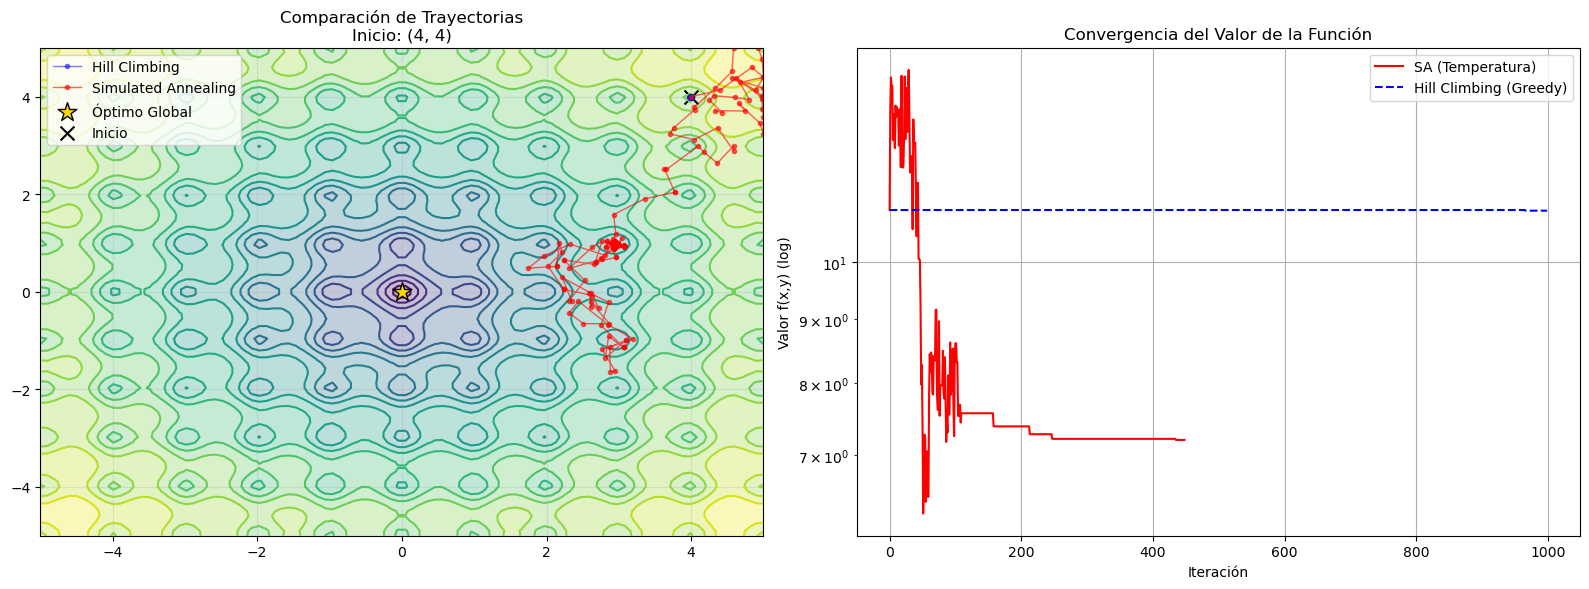

Resultado SA: (1.9634, 0.7378) -> f = 6.285864

EJECUTANDO RANDOM RESTAR SA (10 VECES)
Ejecución 1: Inicio(-1.8, -0.4) -> Final f = 0.096346
Ejecución 2: Inicio(-1.3, -4.4) -> Final f = 2.595298
Ejecución 3: Inicio(1.6, 4.8) -> Final f = 5.433543
Ejecución 4: Inicio(1.6, -4.5) -> Final f = 6.907550
Ejecución 5: Inicio(1.7, 0.7) -> Final f = 0.105813
Ejecución 6: Inicio(0.9, -4.4) -> Final f = 3.585088
Ejecución 7: Inicio(-2.5, 4.0) -> Final f = 0.019989
Ejecución 8: Inicio(0.3, -4.5) -> Final f = 7.662827
Ejecución 9: Inicio(4.7, 3.8) -> Final f = 8.063410
Ejecución 10: Inicio(-4.4, -3.7) -> Final f = 0.049268
----------------------------------------
Mejor valor encontrado: 0.01998862
Promedio de soluciones: 3.45191296
Desviación estándar:    3.18480488


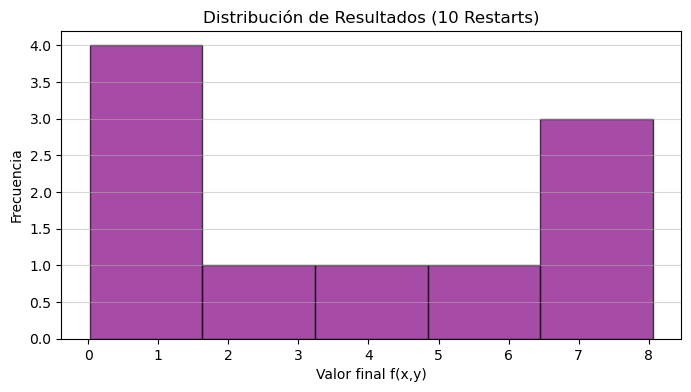

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# ========================================
# 1. Implementación de Ackley
# ========================================
def ackley(x, y):
    """
    Función de Ackley.
    Mínimo global en (0,0) con valor 0.
    """
    # Término 1: La parte exponencial negativa (crea el valle profundo)
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
    
    # Término 2: La parte del coseno (crea las ondulaciones/óptimos locales)
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
    
    return term1 + term2 + np.e + 20

# ========================================
# 2. Implementación de Simulated Annealing
# ========================================
def simulated_annealing_ackley(x_inicial, y_inicial, temp_inicial=100, 
                               tasa_enfriamiento=0.95, max_iter=1000, step_size=0.5):
    
    # Estado actual
    curr_x, curr_y = x_inicial, y_inicial
    curr_f = ackley(curr_x, curr_y)
    
    # Mejor solución encontrada (best found)
    best_x, best_y = curr_x, curr_y
    best_f = curr_f
    
    temp = temp_inicial
    historial = [] # Guardamos (x, y, f)
    
    for i in range(max_iter):
        historial.append((curr_x, curr_y, curr_f))
        
        # 1. Generar vecino (perturbación aleatoria)
        # Usamos distribución uniforme o normal para el paso
        next_x = curr_x + np.random.uniform(-step_size, step_size)
        next_y = curr_y + np.random.uniform(-step_size, step_size)
        
        # Clip para mantenernos dentro del rango del gráfico (-5, 5)
        next_x = np.clip(next_x, -5, 5)
        next_y = np.clip(next_y, -5, 5)
        
        next_f = ackley(next_x, next_y)
        
        # 2. Calcular diferencia de energía
        delta_E = next_f - curr_f
        
        # 3. Criterio de Aceptación (Metropolis)
        # Si mejora (delta_E < 0), aceptamos siempre.
        # Si empeora, aceptamos con probabilidad exp(-delta / T)
        accept = False
        if delta_E < 0:
            accept = True
        else:
            prob = np.exp(-delta_E / temp)
            if random.random() < prob:
                accept = True
                
        if accept:
            curr_x, curr_y = next_x, next_y
            curr_f = next_f
            
            # Actualizar el mejor global si corresponde
            if curr_f < best_f:
                best_x, best_y = curr_x, curr_y
                best_f = curr_f
        
        # 4. Enfriamiento
        temp *= tasa_enfriamiento
        
        # Parada temprana si la temperatura es muy baja
        if temp < 1e-8:
            break
            
    return (best_x, best_y), best_f, historial

# ========================================
# Función Auxiliar: Hill Climbing (Para comparar)
# ========================================
def hill_climbing_ackley(x_inicial, y_inicial, max_iter=1000, step_size=0.5):
    # Es igual que SA pero con Temperatura = 0 (nunca acepta peores movimientos)
    curr_x, curr_y = x_inicial, y_inicial
    curr_f = ackley(curr_x, curr_y)
    historial = []
    
    for _ in range(max_iter):
        historial.append((curr_x, curr_y, curr_f))
        
        next_x = curr_x + np.random.uniform(-step_size, step_size)
        next_y = curr_y + np.random.uniform(-step_size, step_size)
        next_x = np.clip(next_x, -5, 5)
        next_y = np.clip(next_y, -5, 5)
        next_f = ackley(next_x, next_y)
        
        if next_f < curr_f: # Solo acepta si mejora
            curr_x, curr_y = next_x, next_y
            curr_f = next_f
            
    return (curr_x, curr_y), curr_f, historial

# ========================================
# EJECUCIÓN Y VISUALIZACIÓN
# ========================================

# Configuración inicial
start_x, start_y = 4, 4  # Empezamos lejos del centro para ver el camino
temp = 100

# Ejecutar SA
(opt_x, opt_y), opt_val, hist_sa = simulated_annealing_ackley(start_x, start_y, temp_inicial=temp)

# Ejecutar Hill Climbing (para comparar)
_, _, hist_hc = hill_climbing_ackley(start_x, start_y)

# --- GRÁFICOS ---
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = ackley(X, Y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Mapa de contorno con caminos
contour = ax1.contour(X, Y, Z, levels=20, cmap='viridis')
ax1.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.3)

# Extraer coordenadas de los historiales
hx_sa, hy_sa, _ = zip(*hist_sa)
hx_hc, hy_hc, _ = zip(*hist_hc)

# Pintar camino Hill Climbing (Azul - Se estanca)
ax1.plot(hx_hc, hy_hc, 'b.-', alpha=0.5, label='Hill Climbing', linewidth=1)
# Pintar camino Simulated Annealing (Rojo - Explora)
ax1.plot(hx_sa, hy_sa, 'r.-', alpha=0.6, label='Simulated Annealing', linewidth=1)

ax1.scatter([0], [0], color='gold', marker='*', s=200, edgecolors='black', label='Óptimo Global', zorder=10)
ax1.scatter([start_x], [start_y], color='black', marker='x', s=100, label='Inicio')

ax1.set_title(f'Comparación de Trayectorias\nInicio: ({start_x}, {start_y})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Evolución del valor de la función (Convergencia)
vals_sa = [h[2] for h in hist_sa]
vals_hc = [h[2] for h in hist_hc]
ax2.plot(vals_sa, 'r-', label='SA (Temperatura)')
ax2.plot(vals_hc, 'b--', label='Hill Climbing (Greedy)')
ax2.set_yscale('log') # Escala logarítmica para ver mejor la convergencia final
ax2.set_xlabel('Iteración')
ax2.set_ylabel('Valor f(x,y) (log)')
ax2.set_title('Convergencia del Valor de la Función')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Resultado SA: ({opt_x:.4f}, {opt_y:.4f}) -> f = {opt_val:.6f}")


# ========================================
# DESAFÍO: Random Restart
# ========================================
num_restarts = 10
resultados_finales = []

print("\n" + "="*40)
print("EJECUTANDO RANDOM RESTAR SA (10 VECES)")
print("="*40)

for i in range(num_restarts):
    # Generar punto de inicio aleatorio en [-5, 5]
    rx = np.random.uniform(-5, 5)
    ry = np.random.uniform(-5, 5)
    
    (bx, by), bval, _ = simulated_annealing_ackley(rx, ry, temp_inicial=150)
    resultados_finales.append(bval)
    print(f"Ejecución {i+1}: Inicio({rx:.1f}, {ry:.1f}) -> Final f = {bval:.6f}")

# Estadísticas
mejor_de_todos = min(resultados_finales)
promedio = np.mean(resultados_finales)
desviacion = np.std(resultados_finales)

print("-" * 40)
print(f"Mejor valor encontrado: {mejor_de_todos:.8f}")
print(f"Promedio de soluciones: {promedio:.8f}")
print(f"Desviación estándar:    {desviacion:.8f}")

# Histograma simple
plt.figure(figsize=(8, 4))
plt.hist(resultados_finales, bins=5, color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribución de Resultados (10 Restarts)')
plt.xlabel('Valor final f(x,y)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.show()

## 🟡 Ejercicio 2: Optimización de Playlist Musical (Nivel Intermedio)

**Tiempo estimado:** 35-40 minutos  
**Dificultad:** ⭐⭐ Media  

### 📋 Enunciado

Una aplicación de música quiere crear la **playlist perfecta** de 10 canciones. Cada canción tiene:
- **Energía** (1-10): qué tan animada es
- **Popularidad** (1-10): qué tan conocida es
- **Duración** (segundos)
- **Género**: Rock, Pop, Jazz, Electrónica, Clásica

### 🎯 Restricciones y Objetivos

**Restricciones duras:**
1. Duración total: 30-35 minutos
2. No más de 3 canciones consecutivas del mismo género
3. La diferencia de energía entre canciones consecutivas no debe ser > 5

**Objetivos (maximizar):**
1. Popularidad promedio alta
2. Variedad de géneros (bonus por diversidad)
3. Transiciones suaves de energía
4. Empezar con energía media-alta (primera canción 6-8)
5. Terminar con energía media-baja (última canción 4-6)

### 📊 Base de Datos de Canciones

```python
canciones = [
    {'id': 0, 'titulo': 'Thunderstruck', 'energia': 9, 'popularidad': 9, 'duracion': 292, 'genero': 'Rock'},
    {'id': 1, 'titulo': 'Bohemian Rhapsody', 'energia': 7, 'popularidad': 10, 'duracion': 354, 'genero': 'Rock'},
    {'id': 2, 'titulo': 'Shape of You', 'energia': 8, 'popularidad': 10, 'duracion': 234, 'genero': 'Pop'},
    {'id': 3, 'titulo': 'Blinding Lights', 'energia': 9, 'popularidad': 9, 'duracion': 200, 'genero': 'Pop'},
    {'id': 4, 'titulo': 'Fly Me to the Moon', 'energia': 4, 'popularidad': 8, 'duracion': 148, 'genero': 'Jazz'},
    {'id': 5, 'titulo': 'Take Five', 'energia': 5, 'popularidad': 7, 'duracion': 324, 'genero': 'Jazz'},
    {'id': 6, 'titulo': 'Strobe', 'energia': 8, 'popularidad': 6, 'duracion': 644, 'genero': 'Electrónica'},
    {'id': 7, 'titulo': 'Midnight City', 'energia': 9, 'popularidad': 7, 'duracion': 244, 'genero': 'Electrónica'},
    {'id': 8, 'titulo': 'Clair de Lune', 'energia': 2, 'popularidad': 8, 'duracion': 300, 'genero': 'Clásica'},
    {'id': 9, 'titulo': 'Für Elise', 'energia': 3, 'popularidad': 9, 'duracion': 176, 'genero': 'Clásica'},
    {'id': 10, 'titulo': 'Sweet Child O Mine', 'energia': 8, 'popularidad': 9, 'duracion': 356, 'genero': 'Rock'},
    {'id': 11, 'titulo': 'Uptown Funk', 'energia': 10, 'popularidad': 10, 'duracion': 269, 'genero': 'Pop'},
    {'id': 12, 'titulo': 'Summertime', 'energia': 3, 'popularidad': 7, 'duracion': 212, 'genero': 'Jazz'},
    {'id': 13, 'titulo': 'Opus', 'energia': 7, 'popularidad': 5, 'duracion': 539, 'genero': 'Electrónica'},
    {'id': 14, 'titulo': 'Canon in D', 'energia': 4, 'popularidad': 9, 'duracion': 324, 'genero': 'Clásica'}
]
```

### ✅ Tareas

1. **Implementar función de costo** que evalúe:
   - Penalizaciones por restricciones violadas
   - Bonificaciones por objetivos cumplidos

2. **Implementar vecino**: Intercambiar dos canciones en la playlist

3. **Implementar Simulated Annealing**

4. **Visualizar**:
   - Gráfico de energía a lo largo de la playlist
   - Distribución de géneros
   - Convergencia del algoritmo

### 💡 Ejemplo de Función de Costo

```python
costo = 0

# Penalización por duración incorrecta
if duracion_total < 1800 or duracion_total > 2100:
    costo += 100

# Penalización por géneros consecutivos
for i in range(len(playlist) - 2):
    if mismo_genero_3_consecutivas:
        costo += 50

# Penalización por saltos bruscos de energía
for i in range(len(playlist) - 1):
    diferencia_energia = abs(playlist[i].energia - playlist[i+1].energia)
    if diferencia_energia > 5:
        costo += 20

# Bonus por popularidad (queremos maximizar, así que restamos)
costo -= popularidad_promedio * 5

# Bonus por variedad de géneros
costo -= len(set(generos)) * 10
```

### 🎯 Preguntas de Reflexión

1. ¿Qué temperatura inicial funciona mejor para este problema?
2. ¿Cómo afecta la tasa de enfriamiento a la calidad de la playlist?
3. ¿Es mejor empezar con una playlist aleatoria o una semi-ordenada?
4. ¿Qué pasa si ejecutas el algoritmo 20 veces? ¿Son consistentes los resultados?

In [ ]:
# ========================================
# EJERCICIO 2: OPTIMIZACIÓN DE PLAYLIST
# ========================================

# Base de datos de canciones disponibles
canciones = [
    {'id': 0, 'titulo': 'Thunderstruck', 'energia': 9, 'popularidad': 9, 'duracion': 292, 'genero': 'Rock'},
    {'id': 1, 'titulo': 'Bohemian Rhapsody', 'energia': 7, 'popularidad': 10, 'duracion': 354, 'genero': 'Rock'},
    {'id': 2, 'titulo': 'Shape of You', 'energia': 8, 'popularidad': 10, 'duracion': 234, 'genero': 'Pop'},
    {'id': 3, 'titulo': 'Blinding Lights', 'energia': 9, 'popularidad': 9, 'duracion': 200, 'genero': 'Pop'},
    {'id': 4, 'titulo': 'Fly Me to the Moon', 'energia': 4, 'popularidad': 8, 'duracion': 148, 'genero': 'Jazz'},
    {'id': 5, 'titulo': 'Take Five', 'energia': 5, 'popularidad': 7, 'duracion': 324, 'genero': 'Jazz'},
    {'id': 6, 'titulo': 'Strobe', 'energia': 8, 'popularidad': 6, 'duracion': 644, 'genero': 'Electrónica'},
    {'id': 7, 'titulo': 'Midnight City', 'energia': 9, 'popularidad': 7, 'duracion': 244, 'genero': 'Electrónica'},
    {'id': 8, 'titulo': 'Clair de Lune', 'energia': 2, 'popularidad': 8, 'duracion': 300, 'genero': 'Clásica'},
    {'id': 9, 'titulo': 'Für Elise', 'energia': 3, 'popularidad': 9, 'duracion': 176, 'genero': 'Clásica'},
    {'id': 10, 'titulo': 'Sweet Child O Mine', 'energia': 8, 'popularidad': 9, 'duracion': 356, 'genero': 'Rock'},
    {'id': 11, 'titulo': 'Uptown Funk', 'energia': 10, 'popularidad': 10, 'duracion': 269, 'genero': 'Pop'},
    {'id': 12, 'titulo': 'Summertime', 'energia': 3, 'popularidad': 7, 'duracion': 212, 'genero': 'Jazz'},
    {'id': 13, 'titulo': 'Opus', 'energia': 7, 'popularidad': 5, 'duracion': 539, 'genero': 'Electrónica'},
    {'id': 14, 'titulo': 'Canon in D', 'energia': 4, 'popularidad': 9, 'duracion': 324, 'genero': 'Clásica'}
]

print("=" * 70)
print("EJERCICIO 2: Creación de Playlist Perfecta con Simulated Annealing")
print("=" * 70)

print("\n🎵 CANCIONES DISPONIBLES:\n")
print(f"{'ID':<4} {'Título':<25} {'Energía':<10} {'Popular.':<12} {'Duración':<12} {'Género'}")
print("-" * 80)
for c in canciones:
    duracion_min = f"{c['duracion']//60}:{c['duracion']%60:02d}"
    print(f"{c['id']:<4} {c['titulo']:<25} {c['energia']:<10} {c['popularidad']:<12} {duracion_min:<12} {c['genero']}")

print("\n🎯 OBJETIVO: Crear playlist de 10 canciones optimizando:")
print("   • Popularidad total")
print("   • Variedad de géneros")
print("   • Transiciones suaves de energía")
print("   • Duración: 30-35 minutos")

print("\n⚠️ RESTRICCIONES:")
print("   • No más de 3 canciones consecutivas del mismo género")
print("   • Diferencia de energía entre canciones consecutivas ≤ 5")
print("   • Primera canción: energía 6-8 (inicio energético)")
print("   • Última canción: energía 4-6 (cierre relajado)")


# TODO: Implementar función de evaluación
def evaluar_playlist(playlist_ids, canciones):
    """
    Evalúa la calidad de una playlist.
    
    Parámetros:
    - playlist_ids: lista de 10 IDs de canciones
    - canciones: base de datos de canciones
    
    Retorna:
    - costo: menor es mejor (penalizaciones - bonificaciones)
    """
    pass  # Implementar aquí


# TODO: Implementar generador de vecinos
def generar_vecino_playlist(playlist_actual):
    """
    Genera una playlist vecina intercambiando dos canciones.
    
    Parámetros:
    - playlist_actual: lista de IDs actuales
    
    Retorna:
    - nueva playlist con dos canciones intercambiadas
    """
    pass  # Implementar aquí


# TODO: Implementar Simulated Annealing
def simulated_annealing_playlist(canciones, temp_inicial=100, 
                                  tasa_enfriamiento=0.98, max_iter=2000):
    """
    Optimiza una playlist usando Simulated Annealing.
    
    Retorna:
    - mejor_playlist: lista de 10 IDs de canciones
    - mejor_costo: costo de la mejor playlist
    - historial: lista de costos en cada iteración
    """
    pass  # Implementar aquí


print("\n💡 TAREAS:")
print("   1. Implementa evaluar_playlist() con todas las restricciones")
print("   2. Implementa generar_vecino_playlist()")
print("   3. Implementa simulated_annealing_playlist()")
print("   4. Visualiza la playlist óptima:")
print("      - Gráfico de energía a lo largo de las canciones")
print("      - Pie chart de distribución de géneros")
print("      - Timeline de duración")
print("   5. Compara 5 ejecuciones diferentes")
print("\n🎨 VISUALIZACIONES SUGERIDAS:")
print("   • Energía vs posición en playlist (línea)")
print("   • Duración acumulada (barras apiladas)")
print("   • Distribución de géneros (pie chart)")
print("   • Mapa de calor: transiciones de género")